--- Sequential BV (measure-at-end) ---


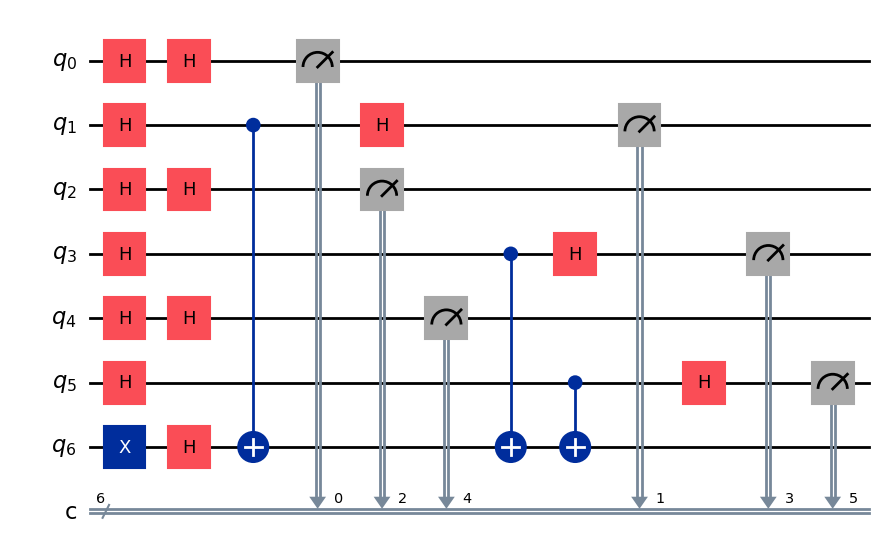

In [6]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.dagcircuit import DAGOpNode
import stim

s = '101010'
n = len(s)
qc_seq = QuantumCircuit(n + 1, n)

# Ancilla prep
qc_seq.x(n)
qc_seq.h(n)
for i in range(n):
    qc_seq.h(i)
    if s[n - 1 - i] == '1':
        qc_seq.cx(i, n)
    qc_seq.h(i)

for i in range(n):
    qc_seq.measure(i, i)

print("--- Sequential BV (measure-at-end) ---")
display(qc_seq.draw('mpl'))

In [2]:
from circuit_analysis import find_qubit_reuse_pairs, modify_circuit, last_index_operation, first_index_operation
import sys

def apply_caqr(qc: QuantumCircuit):
    cur_qc = qc.copy()
    reuse_pairs = find_qubit_reuse_pairs(cur_qc)
    print(f"\nInitial reusable pairs: {reuse_pairs}")
    iter_count = 0
    chain = []
    weight = (1, 1, 1)


    while len(reuse_pairs) > 0 and iter_count < len(qc.qubits) - 1:
        depth_diff = sys.maxsize    
        lst_index = last_index_operation(cur_qc)
        fst_index = first_index_operation(cur_qc)
        
        for i in range(len(reuse_pairs)):
            test_qc = cur_qc.copy()
            test_out_qc = modify_circuit(test_qc, reuse_pairs[i])

            if weight[0]*(test_out_qc.depth() - cur_qc.depth()) + weight[1]* lst_index[reuse_pairs[i][0]]+weight[2]*abs(lst_index[reuse_pairs[i][0]] - fst_index[reuse_pairs[i][1]]) < depth_diff:
                depth_diff = test_out_qc.depth() - cur_qc.depth() + 0.5*lst_index[reuse_pairs[i][0]]
                best_pair = reuse_pairs[i]

        # print(f"Best pair: {best_pair}")
        chain.append((best_pair[0], best_pair[1]))
        modified_qc = modify_circuit(cur_qc, best_pair)
        # print(modified_qc)

        reuse_pairs = find_qubit_reuse_pairs(modified_qc)
        cur_qc = modified_qc.copy()
        iter_count += 1
        lst_index = last_index_operation(cur_qc)

    return cur_qc, iter_count, chain


Initial reusable pairs: []

--- Optimized Circuit ---
Depth: 9
Qubits: 7
Reused 0 qubit(s)
Reuse chain: []


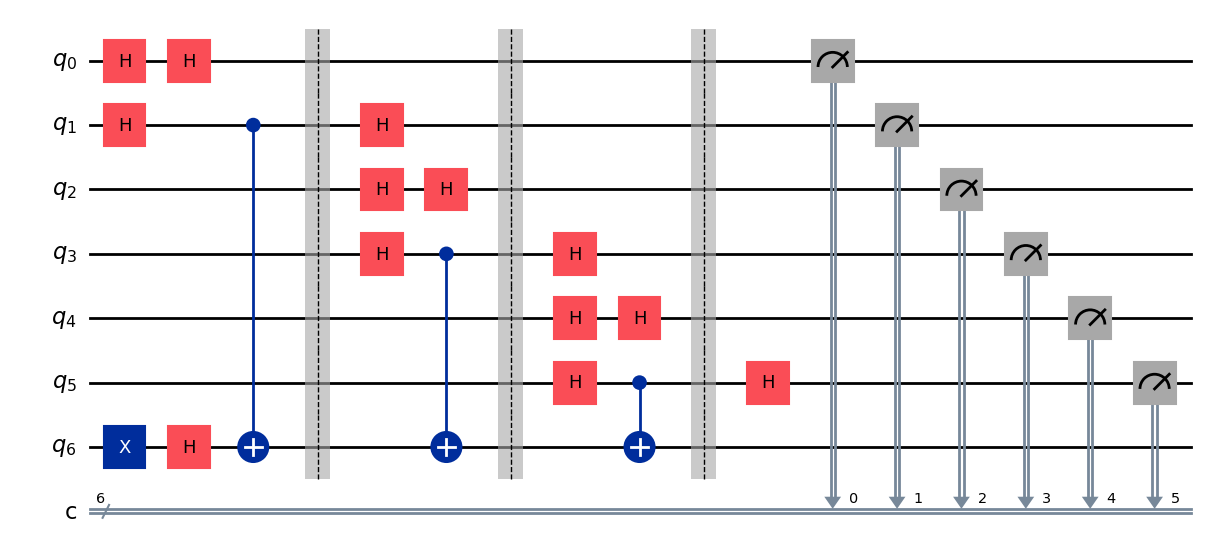

In [3]:
cur_qc, iter_count, chain = apply_caqr(qc_seq)

print(f"\n--- Optimized Circuit ---")
print(f"Depth: {cur_qc.depth()}")
print(f"Qubits: {cur_qc.num_qubits}")
print(f"Reused {iter_count} qubit(s)")
print(f"Reuse chain: {chain}")
display(cur_qc.draw('mpl'))

TESTING ORIGINAL BV CIRCUIT (before CAQR)

--- Testing Original BV ---
Expected secret string: 101010
Measurement results:
  101010: 1000 (100.0%) ✓
✓ SUCCESS: Circuit correctly identifies secret string!


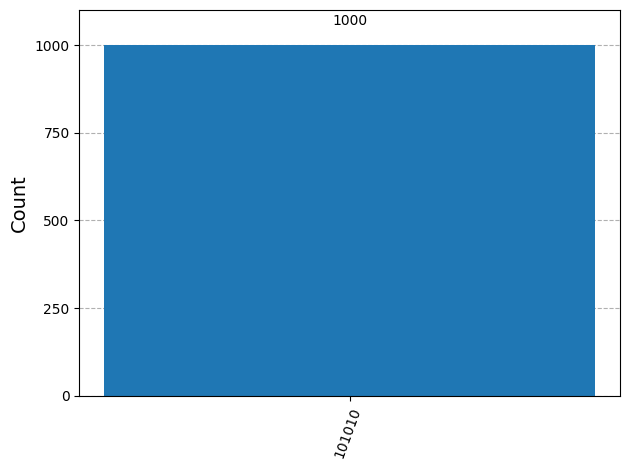


TESTING OPTIMIZED BV CIRCUIT (after CAQR)

--- Testing CAQR Optimized ---
Expected secret string: 101010
Measurement results:
  101010: 1000 (100.0%) ✓
✓ SUCCESS: Circuit correctly identifies secret string!


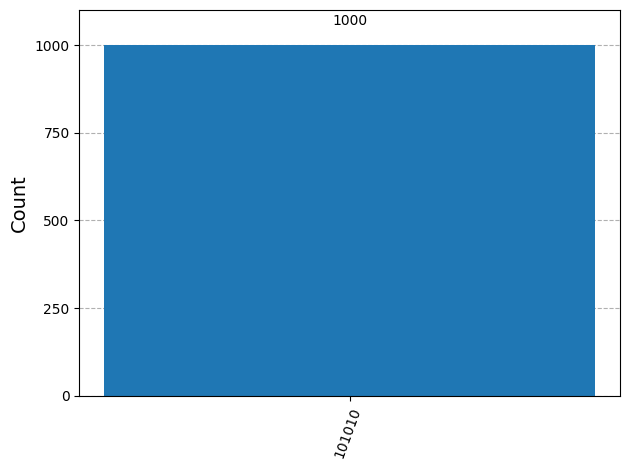

True

In [20]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

def test_bv_circuit(qc, secret_string, circuit_name="Circuit"):
    test_qc = qc.copy()

    simulator = AerSimulator()
    job = simulator.run(test_qc, shots=1000)
    result = job.result()
    counts = result.get_counts()
    
    print(f"\n--- Testing {circuit_name} ---")
    print(f"Expected secret string: {secret_string}")
    print(f"Measurement results:")
    
    most_common = max(counts, key=counts.get)
    
    n = len(secret_string)
    
    for key, count in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        measured_bits = key[-n:] if len(key) >= n else key
        percentage = 100 * count / 1000
        match = "✓" if measured_bits == secret_string else "✗"
        print(f"  {measured_bits}: {count:4d} ({percentage:5.1f}%) {match}")
    
    result_bits = most_common[-n:] if len(most_common) >= n else most_common
    is_correct = result_bits == secret_string
    
    if is_correct:
        print(f"✓ SUCCESS: Circuit correctly identifies secret string!")
    else:
        print(f"✗ FAILED: Got {result_bits}, expected {secret_string}")
    
    display(plot_histogram(counts))
    
    return is_correct

# Test original BV circuit
print("="*60)
print("TESTING ORIGINAL BV CIRCUIT (before CAQR)")
print("="*60)
test_bv_circuit(qc_seq, s, "Original BV")

# Test optimized circuit
print("\n" + "="*60)
print("TESTING OPTIMIZED BV CIRCUIT (after CAQR)")
print("="*60)
test_bv_circuit(cur_qc, s, "CAQR Optimized")

In [21]:
from qiskit import QuantumCircuit

def qubit_segment_lifetimes(qc: QuantumCircuit):
    """
    Compute lifetimes as segments between RESETs.

    Model:
    - Treat each instruction in qc.data as a discrete time step t = 0,1,2,...
    - For each qubit, maintain a "current segment" that starts on the first
      non-reset operation that touches it.
    - A segment ends *immediately before* a reset on that qubit.
      (So the reset operation itself is not counted as part of the segment.)
    - After a reset, the next non-reset operation starts a new segment.
    - At the end of the circuit, any open segments are closed at their last
      non-reset time.

    Returns:
    --------
    segments_per_qubit : list[list[int]]
        For each qubit i, a list of segment lengths (in time steps).
    """

    n_qubits = qc.num_qubits

    # Map each Qubit object to an integer index
    qubit_index = {qb: i for i, qb in enumerate(qc.qubits)}

    # For each qubit:
    # - segment_start[i]: index t where current segment started, or None
    # - last_nonreset_t[i]: last time step with a non-reset op touching this qubit
    segment_start = [None] * n_qubits
    last_nonreset_t = [None] * n_qubits
    segments_per_qubit = [[] for _ in range(n_qubits)]

    for t, inst in enumerate(qc.data):
        # Get op name in a version-robust way
        op = getattr(inst, "operation", getattr(inst, "op", None))
        op_name = getattr(op, "name", "") if op is not None else ""

        qargs = [qubit_index[qb] for qb in inst.qubits]

        if op_name == "reset":
            # Close current segments *before* reset for all affected qubits
            for qi in qargs:
                if segment_start[qi] is not None and last_nonreset_t[qi] is not None:
                    if last_nonreset_t[qi] >= segment_start[qi]:
                        length = last_nonreset_t[qi] - segment_start[qi] + 1
                        if length > 0:
                            segments_per_qubit[qi].append(length)
                # Reset clears current segment
                segment_start[qi] = None
                last_nonreset_t[qi] = None
        else:
            # Normal (non-reset) operation; extend or start segment
            for qi in qargs:
                if segment_start[qi] is None:
                    segment_start[qi] = t
                last_nonreset_t[qi] = t

    # Close any open segments at end of circuit
    for qi in range(n_qubits):
        if segment_start[qi] is not None and last_nonreset_t[qi] is not None:
            if last_nonreset_t[qi] >= segment_start[qi]:
                length = last_nonreset_t[qi] - segment_start[qi] + 1
                if length > 0:
                    segments_per_qubit[qi].append(length)

    return segments_per_qubit


def summarise_segment_lifetimes(qc: QuantumCircuit, name: str):
    """
    Print summary stats:
    - segment lengths per qubit
    - total #segments and total length
    - max segment length
    - average segment length over *all* segments
    - max/avg ratio
    """
    segments_per_qubit = qubit_segment_lifetimes(qc)
    all_segments = [seg for segs in segments_per_qubit for seg in segs]

    total_len = sum(all_segments)
    n_segments = len(all_segments)

    if n_segments > 0:
        max_seg = max(all_segments)
        avg_seg = total_len / n_segments
    else:
        max_seg = 0
        avg_seg = 0.0

    print(f"\n--- {name} ---")
    for i, segs in enumerate(segments_per_qubit):
        print(f"Qubit {i}: segments {segs}")
    print(f"Total #segments:      {n_segments}")
    print(f"Total segment length: {total_len}")
    print(f"Max segment length:   {max_seg}")
    print(f"Avg segment length:   {avg_seg:.2f}")
    if avg_seg > 0:
        print(f"Max/Avg (pre-reset) ratio: {max_seg / avg_seg:.2f}")

    return segments_per_qubit, all_segments

segments_orig, all_segments_orig = summarise_segment_lifetimes(qc_seq, "Original BV")
segments_caqr, all_segments_caqr = summarise_segment_lifetimes(cur_qc, "BV after CaQR")


--- Original BV ---
Qubit 0: segments [16]
Qubit 1: segments [15]
Qubit 2: segments [13]
Qubit 3: segments [12]
Qubit 4: segments [10]
Qubit 5: segments [9]
Qubit 6: segments [16]
Total #segments:      7
Total segment length: 91
Max segment length:   16
Avg segment length:   13.00
Max/Avg (pre-reset) ratio: 1.23

--- BV after CaQR ---
Qubit 0: segments [3, 4, 3, 3, 4, 4]
Qubit 1: segments []
Qubit 2: segments []
Qubit 3: segments []
Qubit 4: segments []
Qubit 5: segments []
Qubit 6: segments [26]
Total #segments:      7
Total segment length: 47
Max segment length:   26
Avg segment length:   6.71
Max/Avg (pre-reset) ratio: 3.87


In [22]:
import stim
from qiskit import QuantumCircuit

def qiskit_to_stim_circuit_with_noise(
    qc: QuantumCircuit,
    p1: float = 0.0,
    p2: float = 0.0,
) -> stim.Circuit:
    """Convert a Qiskit circuit to a Stim circuit, optionally adding noise."""
    single_qubit_gate_map = {
        "h": "H",
        "x": "X",
        "y": "Y",
        "z": "Z",
        "s": "S",
        "sdg": "S_DAG",
        "sx": "SQRT_X",
        "measure": "MR",
        "reset": "R",
    }

    stim_circuit = stim.Circuit()

    for gate in qc:
        op_name = gate.operation.name.lower()
        qubit = qc.find_bit(gate.qubits[0])[0]

        if op_name in single_qubit_gate_map:
            stim_op = single_qubit_gate_map[op_name]
            stim_circuit.append(stim_op, [qubit])

            # Add 1-qubit depolarising noise *after* non-measure/non-reset gates
            if p1 > 0 and op_name not in ["measure", "reset"]:
                stim_circuit.append("DEPOLARIZE1", [qubit], p1)

        elif op_name == "cx":
            target = qc.find_bit(gate.qubits[1])[0]
            stim_circuit.append("CX", [qubit, target])

            if p2 > 0:
                stim_circuit.append("DEPOLARIZE2", [qubit, target], p2)

        elif op_name == "barrier":
            stim_circuit.append("TICK")

        else:
            raise ValueError(f"Unsupported gate: {op_name}")

    return stim_circuit

In [23]:
import numpy as np

def run_bv_on_stim(
    qc: QuantumCircuit,
    secret_string: str,
    p1: float = 0.0,
    p2: float = 0.0,
    shots: int = 20_000,
    label: str = "BV on Stim",
) -> float:
    n = len(secret_string)

    # print(f"\n--- {label} ---")
    # print(f"Secret string: {secret_string}")
    # print(f"Noise: p1={p1}, p2={p2}, shots={shots}")

    stim_circuit = qiskit_to_stim_circuit_with_noise(qc, p1=p1, p2=p2)

    # 2) Build measurement -> classical-bit mapping
    #    meas_map[k] = classical_bit_index that Stim measurement k writes to
    meas_map = []
    meas_counter = 0

    # Build a map from classical bit objects to indices
    clbit_index = {cb: idx for idx, cb in enumerate(qc.clbits)}

    for gate in qc:
        op_name = gate.operation.name.lower()
        if op_name == "measure":
            # Each measure has one qubit and one classical bit
            cbit = gate.clbits[0]
            c_idx = clbit_index[cbit]
            meas_map.append((meas_counter, c_idx))
            meas_counter += 1

    # Sanity: number of measurements seen in Qiskit should equal stim.num_measurements
    num_meas_stim = stim_circuit.num_measurements
    if num_meas_stim != meas_counter:
        print(f"WARNING: Qiskit saw {meas_counter} measures, Stim has {num_meas_stim}.")

    # 3) Sample from Stim
    sampler = stim_circuit.compile_sampler()
    samples = sampler.sample(shots)  # shape (shots, num_measurements)

    # 4) Reconstruct Qiskit-style bitstrings for the BV bits
    # Qiskit bit ordering: in get_counts, for a single classical register of size n,
    # the bitstring's rightmost bit is c[0], then c[1], ..., leftmost is c[n-1].
    # Your test_bv_circuit uses key[-n:], so we match that convention.

    counts = {}

    for shot in samples:
        cvals = [0] * n

        for meas_idx, c_idx in meas_map:
            if c_idx < n:
                cvals[c_idx] = int(shot[meas_idx])

        # reverse to match Qiskit bitstring ordering
        bits = []
        for c_idx in range(n - 1, -1, -1):
            bits.append(str(cvals[c_idx]))
        bitstring = ''.join(bits)

        counts[bitstring] = counts.get(bitstring, 0) + 1

    # print("\nMeasurement distribution (top 10):")
    # for bitstring, count in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    #     pct = 100 * count / shots
    #     match = "✓" if bitstring == secret_string else "✗"
    #     print(f"  {bitstring}: {count:5d} ({pct:5.1f}%) {match}")

    success_prob = counts.get(secret_string, 0) / shots
    # print(f"\nSuccess probability: {success_prob:.4f}")

    return success_prob


In [24]:
print("Noiseless sanity check:")
p_orig = run_bv_on_stim(qc_seq, s, p1=0.0, p2=0.0, shots=5000, label="Original BV (no noise)")
p_caqr = run_bv_on_stim(cur_qc, s, p1=0.0, p2=0.0, shots=5000, label="CAQR BV (no noise)")

print("\nOriginal success:", p_orig)
print("CAQR success:    ", p_caqr)


Noiseless sanity check:

Original success: 1.0
CAQR success:     1.0


In [25]:
for p in [1e-4, 5e-4, 1e-3, 2e-2]:
    print(f"\n=== Gate depolarizing p = {p:.1e} ===")
    p_orig = run_bv_on_stim(qc_seq, s, p1=p, p2=p, shots=20_000, label="Original BV")
    p_caqr = run_bv_on_stim(cur_qc, s, p1=p, p2=p, shots=20_000, label="CAQR BV")
    print(f"Original: {p_orig:.4f},  CAQR: {p_caqr:.4f}")


=== Gate depolarizing p = 1.0e-04 ===
Original: 0.9989,  CAQR: 0.9989

=== Gate depolarizing p = 5.0e-04 ===
Original: 0.9933,  CAQR: 0.9942

=== Gate depolarizing p = 1.0e-03 ===
Original: 0.9885,  CAQR: 0.9885

=== Gate depolarizing p = 2.0e-02 ===
Original: 0.7964,  CAQR: 0.7982


In [26]:
import stim
import pymatching

def estimate_pL_surface_code(distance: int,
                             rounds: int = 10,
                             p_phys: float = 1e-3,
                             shots: int = 50_000) -> float:
    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_x",
        distance=distance,
        rounds=rounds,
        after_clifford_depolarization=p_phys,
    )

    dem = circuit.detector_error_model(decompose_errors=True)
    matching = pymatching.Matching.from_detector_error_model(dem)

    sampler = circuit.compile_detector_sampler()
    syndromes, observables = sampler.sample(
        shots=shots,
        separate_observables=True,
    )

    predicted = matching.decode_batch(syndromes)
    failures = np.sum(np.any(predicted != observables, axis=1))
    p_fail_total = failures / shots
    p_L = p_fail_total / rounds
    return p_L


In [27]:
distances = [3, 5, 7, 9]
p_phys_surface = 1e-2
rounds = 10
shots_pL = 50_000
shots_bv = 20_000

ft_results = []

for d in distances:
    print(f"\n=== Distance d = {d} ===")
    pL = estimate_pL_surface_code(distance=d,
                                  rounds=rounds,
                                  p_phys=p_phys_surface,
                                  shots=shots_pL)
    # Treat pL as effective logical gate error
    p1 = pL
    p2 = pL

    p_orig = run_bv_on_stim(qc_seq, s, p1=p1, p2=p2, shots=shots_bv,
                            label=f"Original BV (d={d})")
    p_caqr = run_bv_on_stim(cur_qc, s, p1=p1, p2=p2, shots=shots_bv,
                            label=f"CAQR BV (d={d})")

    ft_results.append((d, pL, p_orig, p_caqr))

print("\nSummary:")
for d, pL, F_orig, F_caqr in ft_results:
    gain = (F_caqr / F_orig - 1) * 100 if F_orig > 0 else 0.0
    print(f"d={d}: p_L≈{pL:.2e},  F_orig≈{F_orig:.4f},  F_caqr≈{F_caqr:.4f},  gain≈{gain:.2f}%")



=== Distance d = 3 ===

=== Distance d = 5 ===

=== Distance d = 7 ===

=== Distance d = 9 ===

Summary:
d=3: p_L≈8.81e-03,  F_orig≈0.9044,  F_caqr≈0.9030,  gain≈-0.17%
d=5: p_L≈7.46e-03,  F_orig≈0.9175,  F_caqr≈0.9162,  gain≈-0.14%
d=7: p_L≈5.96e-03,  F_orig≈0.9323,  F_caqr≈0.9364,  gain≈0.43%
d=9: p_L≈4.47e-03,  F_orig≈0.9521,  F_caqr≈0.9492,  gain≈-0.30%


In [28]:

def test_caqr_on_all_bv_secret_strings(n):

    # Generate all secret strings of length n
    for i in range(2**n):
        s = format(i, f'0{n}b')  # binary representation with leading zeros

        qc_seq = QuantumCircuit(n + 1, n)

        qc_seq.x(n)
        qc_seq.h(n)

        for j in range(n):
            qc_seq.h(j)
            if s[n - 1 - j] == '1':
                qc_seq.cx(j, n)
            qc_seq.h(j)

        for j in range(n):
            qc_seq.measure(j, j)

        cur_qc = qc_seq.copy()
        reuse_pairs = find_qubit_reuse_pairs(cur_qc)
        iter_count = 0
        chain = []
        weight = (1, 1, 1)


        while len(reuse_pairs) > 0 and iter_count < len(qc_seq.qubits) - 1:
            depth_diff = sys.maxsize    
            lst_index = last_index_operation(cur_qc)
            fst_index = first_index_operation(cur_qc)
            
            for i in range(len(reuse_pairs)):
                test_qc = cur_qc.copy()
                test_out_qc = modify_circuit(test_qc, reuse_pairs[i])

                if weight[0]*(test_out_qc.depth() - cur_qc.depth()) + weight[1]* lst_index[reuse_pairs[i][0]]+weight[2]*abs(lst_index[reuse_pairs[i][0]] - fst_index[reuse_pairs[i][1]]) < depth_diff:
                    depth_diff = test_out_qc.depth() - cur_qc.depth() + 0.5*lst_index[reuse_pairs[i][0]]
                    best_pair = reuse_pairs[i]

            chain.append((best_pair[0], best_pair[1]))
            modified_qc = modify_circuit(cur_qc, best_pair)
            reuse_pairs = find_qubit_reuse_pairs(modified_qc)
            cur_qc = modified_qc.copy()
            iter_count += 1
            lst_index = last_index_operation(cur_qc)
        
        p_orig = run_bv_on_stim(qc_seq, s, p1=0.0, p2=0.0, shots=5000, label="Original BV (no noise)")
        p_caqr = run_bv_on_stim(cur_qc, s, p1=0.0, p2=0.0, shots=5000, label="CAQR BV (no noise)")
        if p_orig != 1.0 or p_caqr != 1.0:
            print(f"Test failed for secret string: {s}")
            return False
        else:
            return True

success = test_caqr_on_all_bv_secret_strings(20)
print("All tests passed!" if success else "Some tests failed.")

All tests passed!


Estimating logical error rate for d=5...
Logical error rate p_L ≈ 7.3480e-03


Testing BV with n=3 (secret string: 111)
CAQR: Reused 2 qubits
Chain: [(0, 1), (0, 2)]
Max/Avg lifetime ratio: 2.15
Fidelity - Original: 0.9475, CAQR: 0.9454

Testing BV with n=4 (secret string: 1111)
CAQR: Reused 3 qubits
Chain: [(0, 1), (0, 2), (0, 3)]
Max/Avg lifetime ratio: 2.71
Fidelity - Original: 0.9313, CAQR: 0.9342

Testing BV with n=5 (secret string: 11111)
CAQR: Reused 4 qubits
Chain: [(0, 1), (0, 2), (0, 3), (0, 4)]
Max/Avg lifetime ratio: 3.27
Fidelity - Original: 0.9157, CAQR: 0.9193

Testing BV with n=6 (secret string: 111111)
CAQR: Reused 5 qubits
Chain: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
Max/Avg lifetime ratio: 3.83
Fidelity - Original: 0.9016, CAQR: 0.9068

Testing BV with n=7 (secret string: 1111111)
CAQR: Reused 6 qubits
Chain: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
Max/Avg lifetime ratio: 4.39
Fidelity - Original: 0.8857, CAQR: 0.8884

Testing BV with n=8 (secret string: 

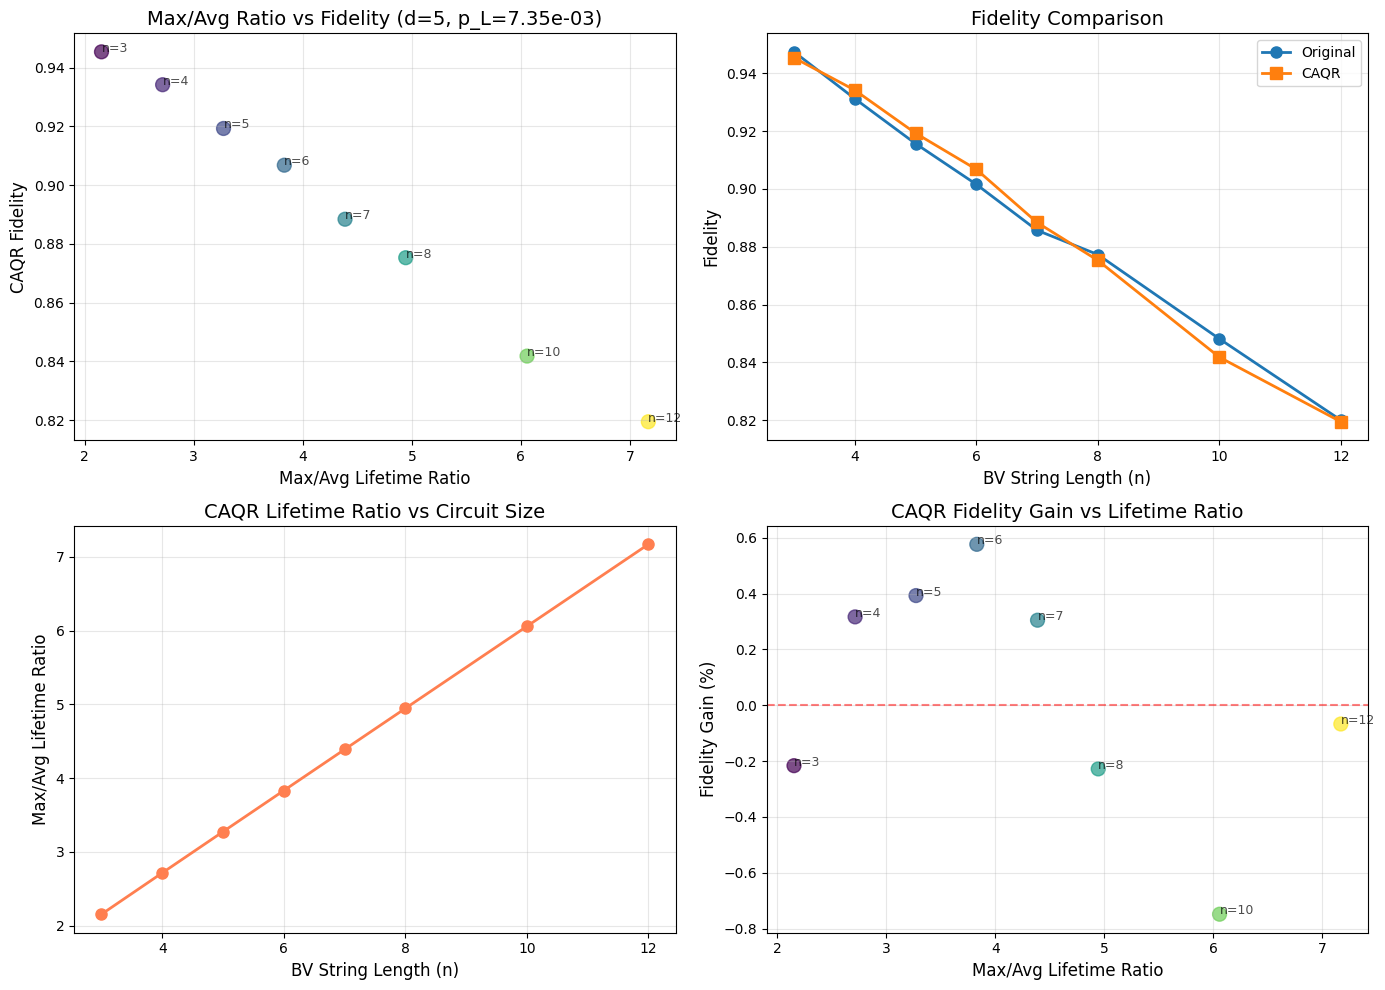


SUMMARY TABLE
  n |  Reuses |  Ratio |  F_orig |  F_caqr |  Gain(%) | D_orig | D_caqr
--------------------------------------------------------------------------------
  3 |       2 |   2.15 |  0.9475 |  0.9454 |    -0.22 |      7 |     15
  4 |       3 |   2.71 |  0.9313 |  0.9342 |     0.32 |      8 |     20
  5 |       4 |   3.27 |  0.9157 |  0.9193 |     0.39 |      9 |     25
  6 |       5 |   3.83 |  0.9016 |  0.9068 |     0.58 |     10 |     30
  7 |       6 |   4.39 |  0.8857 |  0.8884 |     0.30 |     11 |     35
  8 |       7 |   4.94 |  0.8773 |  0.8753 |    -0.23 |     12 |     40
 10 |       9 |   6.06 |  0.8481 |  0.8418 |    -0.75 |     14 |     50
 12 |      11 |   7.17 |  0.8200 |  0.8195 |    -0.07 |     16 |     60


In [29]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_caqr_vs_lifetime_ratio(
    string_lengths: list,
    distance: int = 5,
    rounds: int = 10,
    p_phys_surface: float = 1e-2,
    shots_pL: int = 50_000,
    shots_bv: int = 20_000,
):
    results = []
    
    print(f"Estimating logical error rate for d={distance}...")
    pL = estimate_pL_surface_code(
        distance=distance,
        rounds=rounds,
        p_phys=p_phys_surface,
        shots=shots_pL
    )
    print(f"Logical error rate p_L ≈ {pL:.4e}\n")
    
    for n in string_lengths:
        print(f"\n{'='*60}")
        print(f"Testing BV with n={n} (secret string: {'1'*n})")
        print('='*60)
        
        # Create BV circuit with all 1s
        s = '1' * n
        qc_seq = QuantumCircuit(n + 1, n)
        
        qc_seq.x(n)
        qc_seq.h(n)
        
        for i in range(n):
            qc_seq.h(i)
            if s[n - 1 - i] == '1':
                qc_seq.cx(i, n)
            qc_seq.h(i)
        
        for i in range(n):
            qc_seq.measure(i, i)
        
        # Apply CAQR optimization
        cur_qc = qc_seq.copy()
        reuse_pairs = find_qubit_reuse_pairs(cur_qc)
        iter_count = 0
        chain = []
        weight = (1, 1, 1)
        
        while len(reuse_pairs) > 0 and iter_count < len(qc_seq.qubits) - 1:
            depth_diff = sys.maxsize
            lst_index = last_index_operation(cur_qc)
            fst_index = first_index_operation(cur_qc)
            
            for i in range(len(reuse_pairs)):
                test_qc = cur_qc.copy()
                test_out_qc = modify_circuit(test_qc, reuse_pairs[i])
                
                if weight[0]*(test_out_qc.depth() - cur_qc.depth()) + \
                   weight[1]*lst_index[reuse_pairs[i][0]] + \
                   weight[2]*abs(lst_index[reuse_pairs[i][0]] - fst_index[reuse_pairs[i][1]]) < depth_diff:
                    depth_diff = test_out_qc.depth() - cur_qc.depth() + 0.5*lst_index[reuse_pairs[i][0]]
                    best_pair = reuse_pairs[i]
            
            chain.append((best_pair[0], best_pair[1]))
            modified_qc = modify_circuit(cur_qc, best_pair)
            reuse_pairs = find_qubit_reuse_pairs(modified_qc)
            cur_qc = modified_qc.copy()
            iter_count += 1
            lst_index = last_index_operation(cur_qc)
        
        print(f"CAQR: Reused {iter_count} qubits")
        print(f"Chain: {chain}")
        
        # Calculate lifetime metrics
        segments_orig, all_segments_orig = qubit_segment_lifetimes(qc_seq), None
        segments_caqr, _ = qubit_segment_lifetimes(cur_qc), None
        
        all_segs_caqr = [seg for segs in segments_caqr for seg in segs]
        if len(all_segs_caqr) > 0:
            max_seg = max(all_segs_caqr)
            avg_seg = sum(all_segs_caqr) / len(all_segs_caqr)
            max_avg_ratio = max_seg / avg_seg if avg_seg > 0 else 0
        else:
            max_avg_ratio = 0
        
        print(f"Max/Avg lifetime ratio: {max_avg_ratio:.2f}")
        
        # Test fidelity with surface code noise
        p1 = pL
        p2 = pL
        
        fidelity_orig = run_bv_on_stim(qc_seq, s, p1=p1, p2=p2, shots=shots_bv, 
                                       label=f"Original n={n}")
        fidelity_caqr = run_bv_on_stim(cur_qc, s, p1=p1, p2=p2, shots=shots_bv,
                                       label=f"CAQR n={n}")
        
        print(f"Fidelity - Original: {fidelity_orig:.4f}, CAQR: {fidelity_caqr:.4f}")
        
        results.append({
            'n': n,
            'num_reuses': iter_count,
            'max_avg_ratio': max_avg_ratio,
            'fidelity_orig': fidelity_orig,
            'fidelity_caqr': fidelity_caqr,
            'depth_orig': qc_seq.depth(),
            'depth_caqr': cur_qc.depth(),
        })
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    ratios = [r['max_avg_ratio'] for r in results]
    fidelities_orig = [r['fidelity_orig'] for r in results]
    fidelities_caqr = [r['fidelity_caqr'] for r in results]
    ns = [r['n'] for r in results]
    
    # Plot 1: Max/Avg Ratio vs CAQR Fidelity
    axes[0, 0].scatter(ratios, fidelities_caqr, s=100, alpha=0.7, c=ns, cmap='viridis')
    axes[0, 0].set_xlabel('Max/Avg Lifetime Ratio', fontsize=12)
    axes[0, 0].set_ylabel('CAQR Fidelity', fontsize=12)
    axes[0, 0].set_title(f'Max/Avg Ratio vs Fidelity (d={distance}, p_L={pL:.2e})', fontsize=14)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add labels for each point
    for i, r in enumerate(results):
        axes[0, 0].annotate(f"n={r['n']}", (ratios[i], fidelities_caqr[i]), 
                           fontsize=9, alpha=0.7)
    
    # Plot 2: Original vs CAQR Fidelity
    axes[0, 1].plot(ns, fidelities_orig, 'o-', label='Original', linewidth=2, markersize=8)
    axes[0, 1].plot(ns, fidelities_caqr, 's-', label='CAQR', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('BV String Length (n)', fontsize=12)
    axes[0, 1].set_ylabel('Fidelity', fontsize=12)
    axes[0, 1].set_title('Fidelity Comparison', fontsize=14)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Max/Avg Ratio vs String Length
    axes[1, 0].plot(ns, ratios, 'o-', linewidth=2, markersize=8, color='coral')
    axes[1, 0].set_xlabel('BV String Length (n)', fontsize=12)
    axes[1, 0].set_ylabel('Max/Avg Lifetime Ratio', fontsize=12)
    axes[1, 0].set_title('CAQR Lifetime Ratio vs Circuit Size', fontsize=14)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Fidelity Gain vs Max/Avg Ratio
    fidelity_gains = [(fidelities_caqr[i] / fidelities_orig[i] - 1) * 100 
                     if fidelities_orig[i] > 0 else 0 
                     for i in range(len(results))]
    axes[1, 1].scatter(ratios, fidelity_gains, s=100, alpha=0.7, c=ns, cmap='viridis')
    axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Max/Avg Lifetime Ratio', fontsize=12)
    axes[1, 1].set_ylabel('Fidelity Gain (%)', fontsize=12)
    axes[1, 1].set_title('CAQR Fidelity Gain vs Lifetime Ratio', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)
    
    for i, r in enumerate(results):
        axes[1, 1].annotate(f"n={r['n']}", (ratios[i], fidelity_gains[i]), 
                           fontsize=9, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*80)
    print("SUMMARY TABLE")
    print("="*80)
    print(f"{'n':>3} | {'Reuses':>7} | {'Ratio':>6} | {'F_orig':>7} | {'F_caqr':>7} | {'Gain(%)':>8} | {'D_orig':>6} | {'D_caqr':>6}")
    print("-"*80)
    for i, r in enumerate(results):
        gain = (fidelities_caqr[i] / fidelities_orig[i] - 1) * 100 if fidelities_orig[i] > 0 else 0
        print(f"{r['n']:3d} | {r['num_reuses']:7d} | {r['max_avg_ratio']:6.2f} | "
              f"{r['fidelity_orig']:7.4f} | {r['fidelity_caqr']:7.4f} | {gain:8.2f} | "
              f"{r['depth_orig']:6d} | {r['depth_caqr']:6d}")
    
    return results

# Run the analysis
string_lengths = [3, 4, 5, 6, 7, 8, 10, 12]  # Different BV string lengths
results = analyze_caqr_vs_lifetime_ratio(
    string_lengths=string_lengths,
    distance=5,
    rounds=10,
    p_phys_surface=1e-2,
    shots_pL=50_000,
    shots_bv=20_000,
)

In [30]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def build_xor_n_circuit(input_bits: str) -> QuantumCircuit:
    """
    XOR_n benchmark:
      - n data qubits q[0..n-1] initialised to input_bits
      - 1 ancilla q[n] initialised to |0>
      - ancilla becomes parity(x0..x_{n-1})
      - measure ancilla into single classical bit c_out[0]
    """
    n = len(input_bits)
    assert n >= 1

    q = QuantumRegister(n + 1, "q")
    c_out = ClassicalRegister(1, "out")
    qc = QuantumCircuit(q, c_out)

    # Prepare classical input on q[0..n-1]
    for i, b in enumerate(input_bits):
        if b == "1":
            qc.x(q[i])

    # Ancilla q[n] starts in |0>, compute XOR onto it
    for i in range(n):
        qc.cx(q[i], q[n])

    # Measure ancilla
    qc.measure(q[n], c_out[0])

    return qc


def xor_parity(input_bits: str) -> str:
    """Expected XOR_n output ('0' or '1')."""
    return str(sum(int(b) for b in input_bits) % 2)


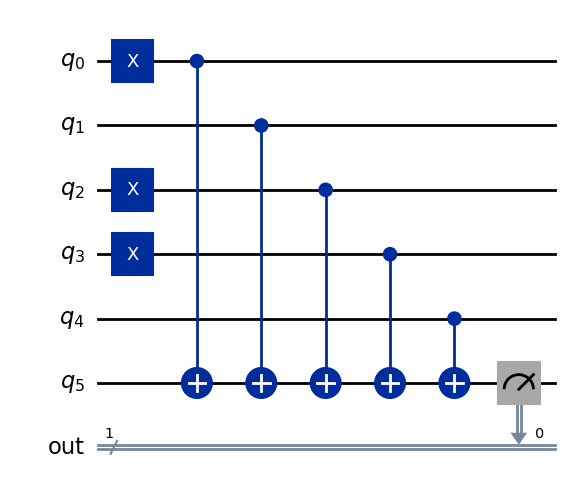

Expected XOR_5 parity: 1


In [ ]:
# test input
xor_input = "10110"
qc_xor5 = build_xor_n_circuit(xor_input)
xor_secret = xor_parity(xor_input)
print("Expected XOR_5 parity:", xor_secret)



--- Original XOR_5 Circuit ---


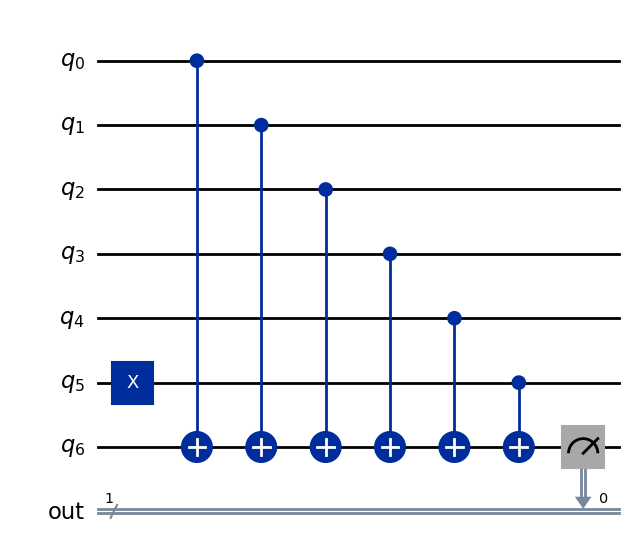


Initial reusable pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]

--- XOR_5 after CaQR ---


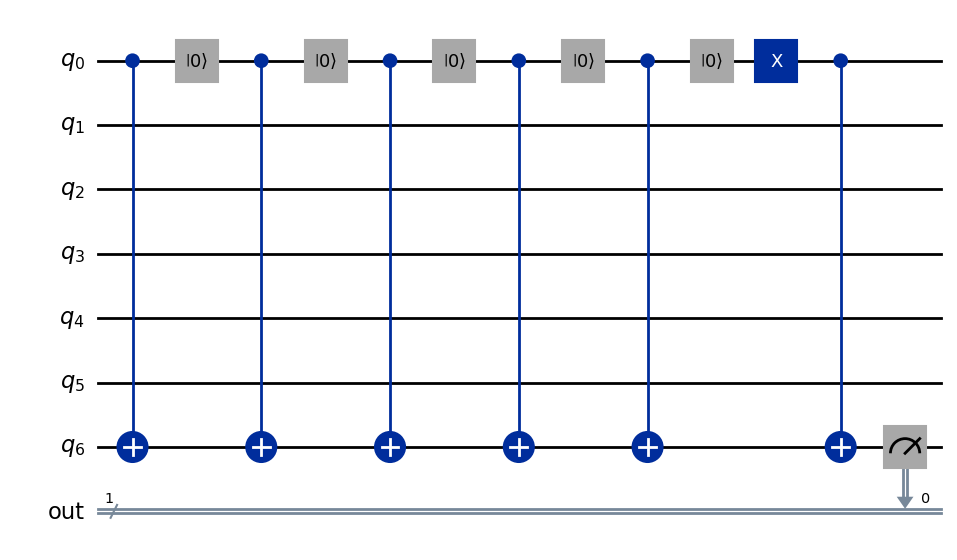

Reused 5 qubit(s)
Reuse chain (XOR_5): [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

--- Testing XOR_5 original ---
Input bits: 000001
Expected XOR parity: 1
Top outcomes:
  1: 2000 (100.0%) ✓
SUCCESS most common = 1

--- Testing XOR_5 after CaQR ---
Input bits: 000001
Expected XOR parity: 1
Top outcomes:
  1: 2000 (100.0%) ✓
SUCCESS most common = 1


True

In [37]:
from qiskit_aer import AerSimulator

# run caqr on it
def test_xor_n_circuit(qc, input_bits: str, circuit_name="XOR_n"):
    secret = xor_parity(input_bits)
    sim = AerSimulator()
    job = sim.run(qc, shots=2000)
    counts = job.result().get_counts()

    print(f"\n--- Testing {circuit_name} ---")
    print(f"Input bits: {input_bits}")
    print(f"Expected XOR parity: {secret}")
    print("Top outcomes:")

    for bitstring, count in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        pct = 100 * count / 2000
        # single output bit is c_out[0] -> last char
        match = "✓" if bitstring[-1] == secret else "✗"
        print(f"  {bitstring}: {count:4d} ({pct:5.1f}%) {match}")

    most_common = max(counts, key=counts.get)
    success = (most_common[-1] == secret)
    print("SUCCESS" if success else "FAIL", "most common =", most_common[-1])
    return success

# example
xor_input = "000001"
qc_xor = build_xor_n_circuit(xor_input)
print("\n--- Original XOR_5 Circuit ---")
display(qc_xor.draw("mpl"))
qc_xor_caqr, xor_iter_count, xor_chain = apply_caqr(qc_xor)
print(f"\n--- XOR_5 after CaQR ---")
display(qc_xor_caqr.draw("mpl"))
print(f"Reused {xor_iter_count} qubit(s)")
print("Reuse chain (XOR_5):", xor_chain)
test_xor_n_circuit(qc_xor, xor_input, "XOR_5 original")
test_xor_n_circuit(qc_xor_caqr, xor_input, "XOR_5 after CaQR")


In [39]:
print("Noiseless sanity (Stim):")
p_orig = run_bv_on_stim(qc_xor, xor_secret, p1=0.0, p2=0.0, shots=5000, label="XOR_5 original")
p_caqr = run_bv_on_stim(qc_xor_caqr, xor_secret, p1=0.0, p2=0.0, shots=5000, label="XOR_5 CaQR")

for p in [1e-4, 5e-4, 1e-3, 2e-2]:
    print(f"\n=== XOR_5 depolarising p={p:.1e} ===")
    p_orig = run_bv_on_stim(qc_xor, xor_secret, p1=p, p2=p, shots=20_000,
                            label=f"XOR_5 original p={p:.1e}")
    p_caqr = run_bv_on_stim(qc_xor_caqr, xor_secret, p1=p, p2=p, shots=20_000,
                            label=f"XOR_5 CaQR p={p:.1e}")
    print(f"Original: {p_orig:.4f}, CaQR: {p_caqr:.4f}")

Noiseless sanity (Stim):

=== XOR_5 depolarising p=1.0e-04 ===
Original: 0.9998, CaQR: 0.9998

=== XOR_5 depolarising p=5.0e-04 ===
Original: 0.9988, CaQR: 0.9977

=== XOR_5 depolarising p=1.0e-03 ===
Original: 0.9963, CaQR: 0.9966

=== XOR_5 depolarising p=2.0e-02 ===
Original: 0.9268, CaQR: 0.9281


Estimating logical error rate for d=5...
Logical error rate p_L ≈ 7.5160e-03


Testing XOR_3 (input: 111)

Initial reusable pairs: [(0, 1), (0, 2), (1, 2)]
CAQR: Reused 2 qubits
Chain: [(0, 1), (0, 2)]
Max/Avg lifetime ratio: 2.29
Fidelity - Original: 0.9740, CAQR: 0.9746

Testing XOR_5 (input: 11111)

Initial reusable pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
CAQR: Reused 4 qubits
Chain: [(0, 1), (0, 2), (0, 3), (0, 4)]
Max/Avg lifetime ratio: 3.50
Fidelity - Original: 0.9581, CAQR: 0.9586

Testing XOR_7 (input: 1111111)

Initial reusable pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]
CAQR: Reused 6 qubits
Chain: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
Max/Avg lifetime ratio: 4.71
Fidelity - Original: 0.9421, CAQR: 0.9383

Testing XOR_10 (input: 1111111111)

Initial reusable pairs: [(0, 1), (0, 2), (0, 3

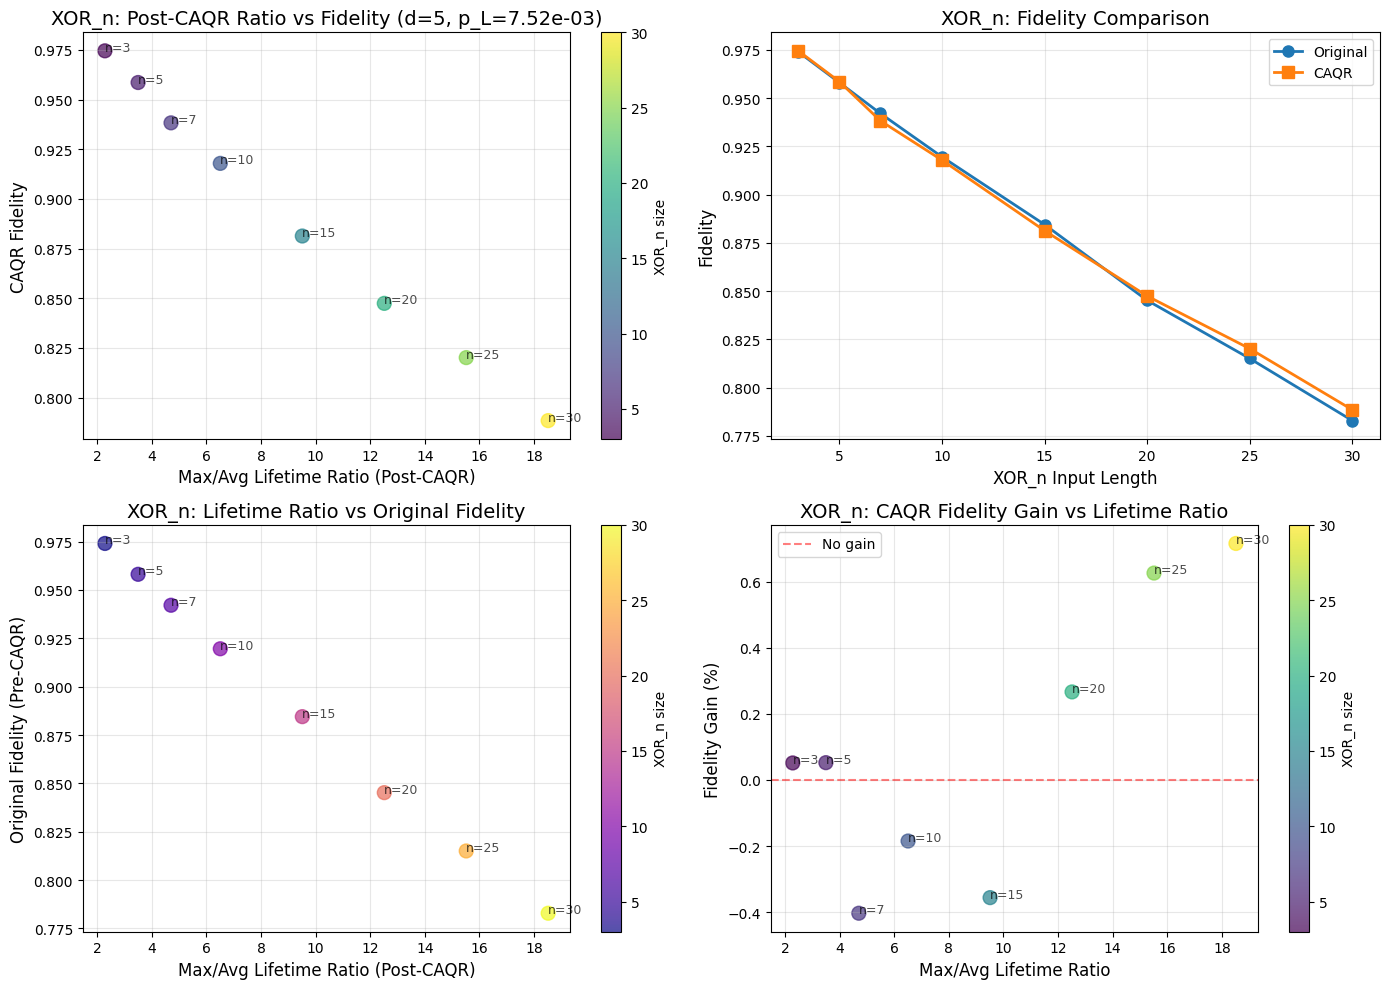


XOR_n SUMMARY TABLE
  n |  Reuses |  Ratio |  F_orig |  F_caqr |  Gain(%) | D_orig | D_caqr
--------------------------------------------------------------------------------
  3 |       2 |   2.29 |  0.9740 |  0.9746 |     0.05 |      5 |      9
  5 |       4 |   3.50 |  0.9581 |  0.9586 |     0.05 |      7 |     15
  7 |       6 |   4.71 |  0.9421 |  0.9383 |    -0.40 |      9 |     21
 10 |       9 |   6.51 |  0.9196 |  0.9179 |    -0.18 |     12 |     30
 15 |      14 |   9.51 |  0.8845 |  0.8813 |    -0.36 |     17 |     45
 20 |      19 |  12.52 |  0.8452 |  0.8475 |     0.27 |     22 |     60
 25 |      24 |  15.52 |  0.8151 |  0.8202 |     0.63 |     27 |     75
 30 |      29 |  18.52 |  0.7829 |  0.7884 |     0.72 |     32 |     90


In [41]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_xor_caqr_vs_lifetime_ratio(
    xor_lengths: list,
    distance: int = 5,
    rounds: int = 10,
    p_phys_surface: float = 1e-2,
    shots_pL: int = 50_000,
    shots_xor: int = 20_000,
):
    """
    For each XOR_n length (all 1s input), run CAQR and measure:
    - Max/Avg lifetime ratio (from qubit segments)
    - Fidelity under surface code noise
    
    Plot the relationship between these metrics.
    """
    results = []
    
    print(f"Estimating logical error rate for d={distance}...")
    pL = estimate_pL_surface_code(
        distance=distance,
        rounds=rounds,
        p_phys=p_phys_surface,
        shots=shots_pL
    )
    print(f"Logical error rate p_L ≈ {pL:.4e}\n")
    
    for n in xor_lengths:
        print(f"\n{'='*60}")
        print(f"Testing XOR_{n} (input: {'1'*n})")
        print('='*60)
        
        # Create XOR_n circuit with all 1s
        xor_input = '1' * n
        xor_secret = xor_parity(xor_input)  # Expected output
        qc_xor = build_xor_n_circuit(xor_input)
        
        # Apply CAQR optimization
        qc_xor_caqr, iter_count, chain = apply_caqr(qc_xor)
        
        print(f"CAQR: Reused {iter_count} qubits")
        print(f"Chain: {chain}")
        
        # Calculate lifetime metrics
        segments_orig = qubit_segment_lifetimes(qc_xor)
        segments_caqr = qubit_segment_lifetimes(qc_xor_caqr)
        
        all_segs_caqr = [seg for segs in segments_caqr for seg in segs]
        if len(all_segs_caqr) > 0:
            max_seg = max(all_segs_caqr)
            avg_seg = sum(all_segs_caqr) / len(all_segs_caqr)
            max_avg_ratio = max_seg / avg_seg if avg_seg > 0 else 0
        else:
            max_avg_ratio = 0
        
        print(f"Max/Avg lifetime ratio: {max_avg_ratio:.2f}")
        
        # Test fidelity with surface code noise
        p1 = pL
        p2 = pL
        
        fidelity_orig = run_bv_on_stim(qc_xor, xor_secret, p1=p1, p2=p2, 
                                       shots=shots_xor, label=f"XOR_{n} Original")
        fidelity_caqr = run_bv_on_stim(qc_xor_caqr, xor_secret, p1=p1, p2=p2, 
                                       shots=shots_xor, label=f"XOR_{n} CAQR")
        
        print(f"Fidelity - Original: {fidelity_orig:.4f}, CAQR: {fidelity_caqr:.4f}")
        
        results.append({
            'n': n,
            'num_reuses': iter_count,
            'max_avg_ratio': max_avg_ratio,
            'fidelity_orig': fidelity_orig,
            'fidelity_caqr': fidelity_caqr,
            'depth_orig': qc_xor.depth(),
            'depth_caqr': qc_xor_caqr.depth(),
        })
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    ratios = [r['max_avg_ratio'] for r in results]
    fidelities_orig = [r['fidelity_orig'] for r in results]
    fidelities_caqr = [r['fidelity_caqr'] for r in results]
    ns = [r['n'] for r in results]
    
    # Plot 1: Max/Avg Ratio vs CAQR Fidelity (Post-CAQR)
    scatter = axes[0, 0].scatter(ratios, fidelities_caqr, s=100, alpha=0.7, c=ns, cmap='viridis')
    axes[0, 0].set_xlabel('Max/Avg Lifetime Ratio (Post-CAQR)', fontsize=12)
    axes[0, 0].set_ylabel('CAQR Fidelity', fontsize=12)
    axes[0, 0].set_title(f'XOR_n: Post-CAQR Ratio vs Fidelity (d={distance}, p_L={pL:.2e})', fontsize=14)
    axes[0, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0, 0], label='XOR_n size')
    
    # Add labels for each point
    for i, r in enumerate(results):
        axes[0, 0].annotate(f"n={r['n']}", (ratios[i], fidelities_caqr[i]), 
                           fontsize=9, alpha=0.7)
    
    # Plot 2: Original vs CAQR Fidelity
    axes[0, 1].plot(ns, fidelities_orig, 'o-', label='Original', linewidth=2, markersize=8)
    axes[0, 1].plot(ns, fidelities_caqr, 's-', label='CAQR', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('XOR_n Input Length', fontsize=12)
    axes[0, 1].set_ylabel('Fidelity', fontsize=12)
    axes[0, 1].set_title('XOR_n: Fidelity Comparison', fontsize=14)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Max/Avg Ratio vs Original Fidelity (Pre-CAQR)
    scatter3 = axes[1, 0].scatter(ratios, fidelities_orig, s=100, alpha=0.7, c=ns, cmap='plasma')
    axes[1, 0].set_xlabel('Max/Avg Lifetime Ratio (Post-CAQR)', fontsize=12)
    axes[1, 0].set_ylabel('Original Fidelity (Pre-CAQR)', fontsize=12)
    axes[1, 0].set_title('XOR_n: Lifetime Ratio vs Original Fidelity', fontsize=14)
    axes[1, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter3, ax=axes[1, 0], label='XOR_n size')
    
    for i, r in enumerate(results):
        axes[1, 0].annotate(f"n={r['n']}", (ratios[i], fidelities_orig[i]), 
                           fontsize=9, alpha=0.7)
    
    # Plot 4: Fidelity Gain vs Max/Avg Ratio
    fidelity_gains = [(fidelities_caqr[i] / fidelities_orig[i] - 1) * 100 
                     if fidelities_orig[i] > 0 else 0 
                     for i in range(len(results))]
    scatter2 = axes[1, 1].scatter(ratios, fidelity_gains, s=100, alpha=0.7, c=ns, cmap='viridis')
    axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='No gain')
    axes[1, 1].set_xlabel('Max/Avg Lifetime Ratio', fontsize=12)
    axes[1, 1].set_ylabel('Fidelity Gain (%)', fontsize=12)
    axes[1, 1].set_title('XOR_n: CAQR Fidelity Gain vs Lifetime Ratio', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    plt.colorbar(scatter2, ax=axes[1, 1], label='XOR_n size')
    
    for i, r in enumerate(results):
        axes[1, 1].annotate(f"n={r['n']}", (ratios[i], fidelity_gains[i]), 
                           fontsize=9, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*80)
    print("XOR_n SUMMARY TABLE")
    print("="*80)
    print(f"{'n':>3} | {'Reuses':>7} | {'Ratio':>6} | {'F_orig':>7} | {'F_caqr':>7} | {'Gain(%)':>8} | {'D_orig':>6} | {'D_caqr':>6}")
    print("-"*80)
    for i, r in enumerate(results):
        gain = (fidelities_caqr[i] / fidelities_orig[i] - 1) * 100 if fidelities_orig[i] > 0 else 0
        print(f"{r['n']:3d} | {r['num_reuses']:7d} | {r['max_avg_ratio']:6.2f} | "
              f"{r['fidelity_orig']:7.4f} | {r['fidelity_caqr']:7.4f} | {gain:8.2f} | "
              f"{r['depth_orig']:6d} | {r['depth_caqr']:6d}")
    
    return results

# Run the analysis for XOR_n
xor_lengths = [3, 5, 7, 10, 15, 20, 25, 30]  # Different XOR_n sizes
xor_results = analyze_xor_caqr_vs_lifetime_ratio(
    xor_lengths=xor_lengths,
    distance=5,
    rounds=10,
    p_phys_surface=1e-2,
    shots_pL=50_000,
    shots_xor=20_000,
)


ANALYZING BV CIRCUITS

Testing BV with n=3

Initial reusable pairs: [(0, 1), (0, 2), (1, 2)]
CAQR: Reused 2 qubits, Chain: [(0, 1), (0, 2)]
Max/Avg lifetime ratio: 2.15
  Testing d=3 (original)... F=0.9394
  Testing d=3 (CAQR)... F=0.9330
✓ Min distance: Original=3, CAQR=3

Testing BV with n=4

Initial reusable pairs: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
CAQR: Reused 3 qubits, Chain: [(0, 1), (0, 2), (0, 3)]
Max/Avg lifetime ratio: 2.71
  Testing d=3 (original)... F=0.9225
  Testing d=3 (CAQR)... F=0.9157
✓ Min distance: Original=3, CAQR=3

Testing BV with n=5

Initial reusable pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
CAQR: Reused 4 qubits, Chain: [(0, 1), (0, 2), (0, 3), (0, 4)]
Max/Avg lifetime ratio: 3.27
  Testing d=3 (original)... F=0.9002
  Testing d=3 (CAQR)... F=0.8995
  Testing d=5 (CAQR)... F=0.9161
✓ Min distance: Original=3, CAQR=5

Testing BV with n=6

Initial reusable pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5

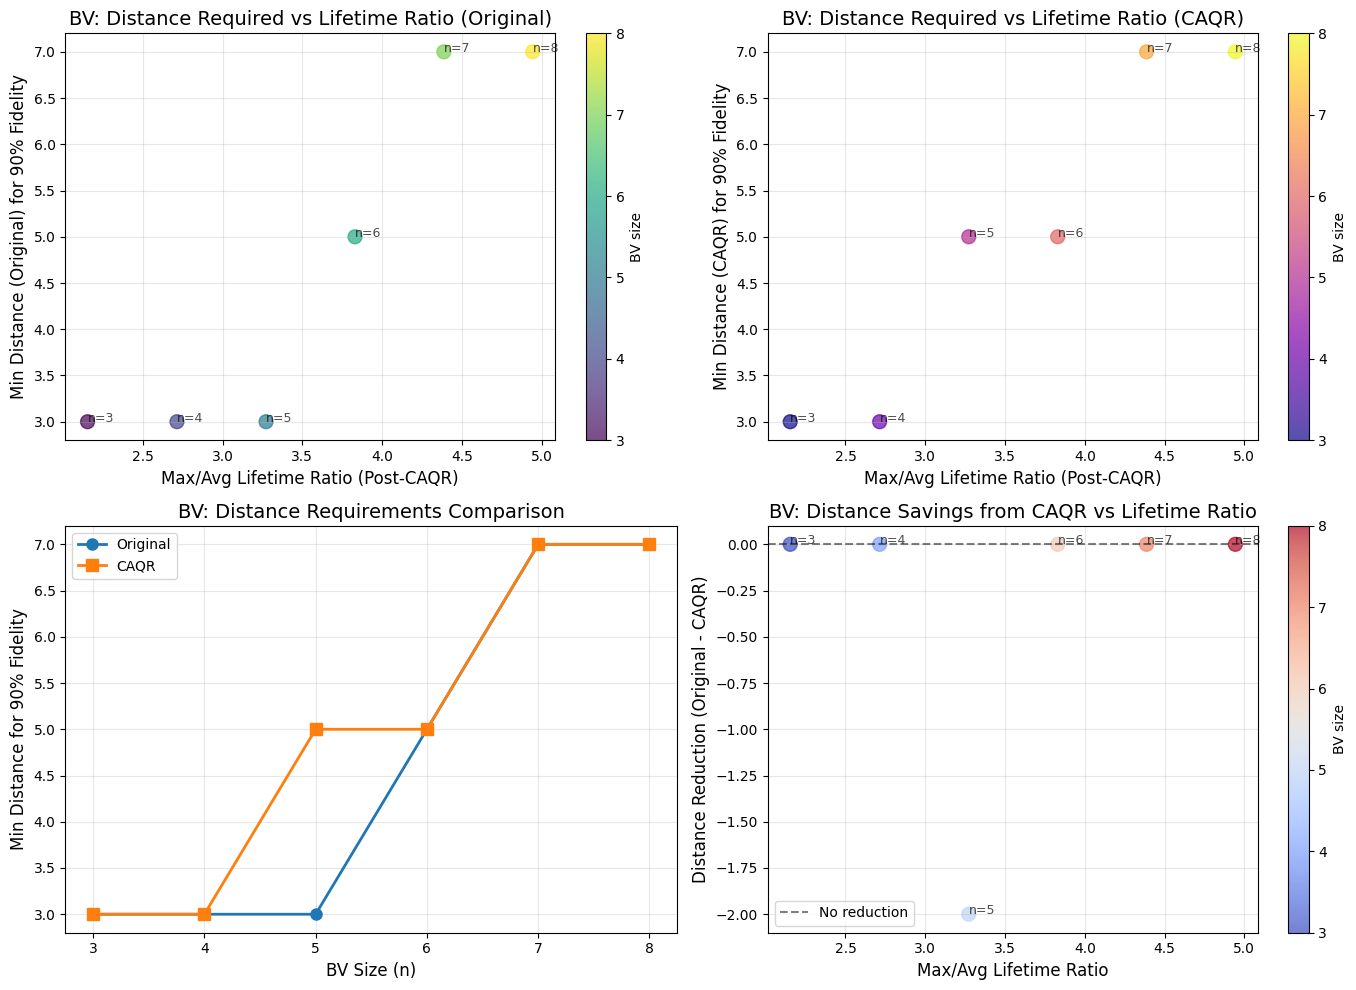


BV DISTANCE REQUIREMENTS FOR 90% FIDELITY
  n |  Reuses |  Ratio |  d_orig |  d_caqr |    Δd |  F_orig |  F_caqr
------------------------------------------------------------------------------------------
  3 |       2 |   2.15 |       3 |       3 |     0 |  0.9394 |  0.9330
  4 |       3 |   2.71 |       3 |       3 |     0 |  0.9225 |  0.9157
  5 |       4 |   3.27 |       3 |       5 |    -2 |  0.9002 |  0.9161
  6 |       5 |   3.83 |       5 |       5 |     0 |  0.9034 |  0.9010
  7 |       6 |   4.39 |       7 |       7 |     0 |  0.9126 |  0.9111
  8 |       7 |   4.94 |       7 |       7 |     0 |  0.9053 |  0.9034


ANALYZING XOR_n CIRCUITS

Testing XOR_n with n=3

Initial reusable pairs: [(0, 1), (0, 2), (1, 2)]
CAQR: Reused 2 qubits, Chain: [(0, 1), (0, 2)]
Max/Avg lifetime ratio: 2.29
  Testing d=3 (original)... F=0.9686
  Testing d=3 (CAQR)... F=0.9685
✓ Min distance: Original=3, CAQR=3

Testing XOR_n with n=5

Initial reusable pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2

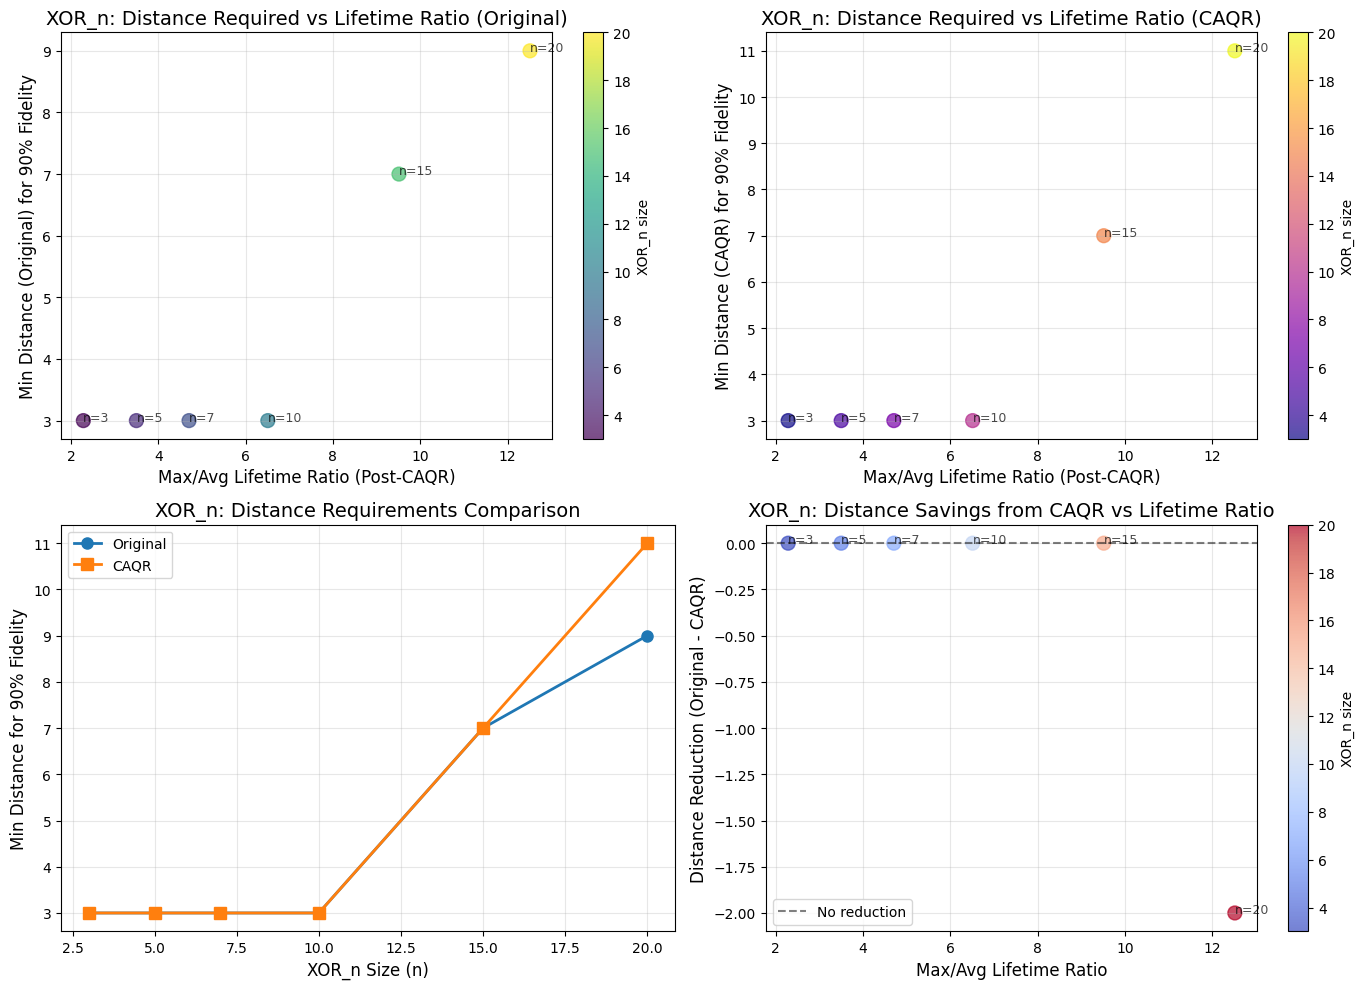


XOR_n DISTANCE REQUIREMENTS FOR 90% FIDELITY
  n |  Reuses |  Ratio |  d_orig |  d_caqr |    Δd |  F_orig |  F_caqr
------------------------------------------------------------------------------------------
  3 |       2 |   2.29 |       3 |       3 |     0 |  0.9686 |  0.9685
  5 |       4 |   3.50 |       3 |       3 |     0 |  0.9502 |  0.9486
  7 |       6 |   4.71 |       3 |       3 |     0 |  0.9318 |  0.9308
 10 |       9 |   6.51 |       3 |       3 |     0 |  0.9080 |  0.9041
 15 |      14 |   9.51 |       7 |       7 |     0 |  0.9080 |  0.9019
 20 |      19 |  12.52 |       9 |      11 |    -2 |  0.9050 |  0.9216


In [42]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_distance_vs_lifetime_ratio(
    string_lengths: list,
    target_fidelity: float = 0.90,
    max_distance: int = 13,
    rounds: int = 10,
    p_phys_surface: float = 1e-2,
    shots_pL: int = 50_000,
    shots_bv: int = 20_000,
    use_bv: bool = True,  # True for BV, False for XOR_n
):
    """
    For each circuit size, find the minimum code distance needed to achieve
    target_fidelity, then plot distance vs max/avg lifetime ratio.
    
    This shows: circuits with better qubit reuse (lower ratio) may need
    lower code distances to achieve the same fidelity target.
    """
    results = []
    
    for n in string_lengths:
        print(f"\n{'='*60}")
        circuit_type = "BV" if use_bv else "XOR_n"
        print(f"Testing {circuit_type} with n={n}")
        print('='*60)
        
        # Build circuit
        if use_bv:
            s = '1' * n
            qc_seq = QuantumCircuit(n + 1, n)
            qc_seq.x(n)
            qc_seq.h(n)
            for i in range(n):
                qc_seq.h(i)
                if s[n - 1 - i] == '1':
                    qc_seq.cx(i, n)
                qc_seq.h(i)
            for i in range(n):
                qc_seq.measure(i, i)
            secret = s
        else:
            xor_input = '1' * n
            qc_seq = build_xor_n_circuit(xor_input)
            secret = xor_parity(xor_input)
        
        # Apply CAQR
        qc_caqr, iter_count, chain = apply_caqr(qc_seq)
        
        print(f"CAQR: Reused {iter_count} qubits, Chain: {chain}")
        
        # Calculate lifetime metrics
        segments_caqr = qubit_segment_lifetimes(qc_caqr)
        all_segs_caqr = [seg for segs in segments_caqr for seg in segs]
        
        if len(all_segs_caqr) > 0:
            max_seg = max(all_segs_caqr)
            avg_seg = sum(all_segs_caqr) / len(all_segs_caqr)
            max_avg_ratio = max_seg / avg_seg if avg_seg > 0 else 0
        else:
            max_avg_ratio = 0
        
        print(f"Max/Avg lifetime ratio: {max_avg_ratio:.2f}")
        
        # Binary search for minimum distance (original circuit)
        min_d_orig = None
        for d in range(3, max_distance + 1, 2):  # Only odd distances
            print(f"  Testing d={d} (original)...", end=" ")
            pL = estimate_pL_surface_code(
                distance=d,
                rounds=rounds,
                p_phys=p_phys_surface,
                shots=shots_pL
            )
            fidelity = run_bv_on_stim(qc_seq, secret, p1=pL, p2=pL, 
                                     shots=shots_bv, label=f"d={d}")
            print(f"F={fidelity:.4f}")
            
            if fidelity >= target_fidelity:
                min_d_orig = d
                fidelity_at_min_d_orig = fidelity
                break
        
        if min_d_orig is None:
            print(f"  ⚠️  Could not achieve {target_fidelity:.0%} fidelity (original)")
            min_d_orig = max_distance + 2  # Mark as "too high"
            fidelity_at_min_d_orig = 0.0
        
        # Binary search for minimum distance (CAQR circuit)
        min_d_caqr = None
        for d in range(3, max_distance + 1, 2):
            print(f"  Testing d={d} (CAQR)...", end=" ")
            pL = estimate_pL_surface_code(
                distance=d,
                rounds=rounds,
                p_phys=p_phys_surface,
                shots=shots_pL
            )
            fidelity = run_bv_on_stim(qc_caqr, secret, p1=pL, p2=pL,
                                     shots=shots_bv, label=f"d={d}")
            print(f"F={fidelity:.4f}")
            
            if fidelity >= target_fidelity:
                min_d_caqr = d
                fidelity_at_min_d_caqr = fidelity
                break
        
        if min_d_caqr is None:
            print(f"  ⚠️  Could not achieve {target_fidelity:.0%} fidelity (CAQR)")
            min_d_caqr = max_distance + 2
            fidelity_at_min_d_caqr = 0.0
        
        print(f"✓ Min distance: Original={min_d_orig}, CAQR={min_d_caqr}")
        
        results.append({
            'n': n,
            'num_reuses': iter_count,
            'max_avg_ratio': max_avg_ratio,
            'min_d_orig': min_d_orig,
            'min_d_caqr': min_d_caqr,
            'distance_reduction': min_d_orig - min_d_caqr,
            'fidelity_orig': fidelity_at_min_d_orig,
            'fidelity_caqr': fidelity_at_min_d_caqr,
        })
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    ratios = [r['max_avg_ratio'] for r in results]
    min_d_orig = [r['min_d_orig'] for r in results]
    min_d_caqr = [r['min_d_caqr'] for r in results]
    distance_reductions = [r['distance_reduction'] for r in results]
    ns = [r['n'] for r in results]
    
    circuit_name = "BV" if use_bv else "XOR_n"
    
    # Plot 1: Min Distance (Original) vs Max/Avg Ratio
    scatter1 = axes[0, 0].scatter(ratios, min_d_orig, s=100, alpha=0.7, c=ns, cmap='viridis')
    axes[0, 0].set_xlabel('Max/Avg Lifetime Ratio (Post-CAQR)', fontsize=12)
    axes[0, 0].set_ylabel(f'Min Distance (Original) for {target_fidelity:.0%} Fidelity', fontsize=12)
    axes[0, 0].set_title(f'{circuit_name}: Distance Required vs Lifetime Ratio (Original)', fontsize=14)
    axes[0, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0, 0], label=f'{circuit_name} size')
    
    for i, r in enumerate(results):
        if r['min_d_orig'] <= max_distance:
            axes[0, 0].annotate(f"n={r['n']}", (ratios[i], min_d_orig[i]), 
                               fontsize=9, alpha=0.7)
    
    # Plot 2: Min Distance (CAQR) vs Max/Avg Ratio
    scatter2 = axes[0, 1].scatter(ratios, min_d_caqr, s=100, alpha=0.7, c=ns, cmap='plasma')
    axes[0, 1].set_xlabel('Max/Avg Lifetime Ratio (Post-CAQR)', fontsize=12)
    axes[0, 1].set_ylabel(f'Min Distance (CAQR) for {target_fidelity:.0%} Fidelity', fontsize=12)
    axes[0, 1].set_title(f'{circuit_name}: Distance Required vs Lifetime Ratio (CAQR)', fontsize=14)
    axes[0, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[0, 1], label=f'{circuit_name} size')
    
    for i, r in enumerate(results):
        if r['min_d_caqr'] <= max_distance:
            axes[0, 1].annotate(f"n={r['n']}", (ratios[i], min_d_caqr[i]), 
                               fontsize=9, alpha=0.7)
    
    # Plot 3: Original vs CAQR Min Distance
    axes[1, 0].plot(ns, min_d_orig, 'o-', label='Original', linewidth=2, markersize=8)
    axes[1, 0].plot(ns, min_d_caqr, 's-', label='CAQR', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel(f'{circuit_name} Size (n)', fontsize=12)
    axes[1, 0].set_ylabel(f'Min Distance for {target_fidelity:.0%} Fidelity', fontsize=12)
    axes[1, 0].set_title(f'{circuit_name}: Distance Requirements Comparison', fontsize=14)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Distance Reduction vs Max/Avg Ratio
    scatter4 = axes[1, 1].scatter(ratios, distance_reductions, s=100, alpha=0.7, c=ns, cmap='coolwarm')
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5, label='No reduction')
    axes[1, 1].set_xlabel('Max/Avg Lifetime Ratio', fontsize=12)
    axes[1, 1].set_ylabel('Distance Reduction (Original - CAQR)', fontsize=12)
    axes[1, 1].set_title(f'{circuit_name}: Distance Savings from CAQR vs Lifetime Ratio', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    plt.colorbar(scatter4, ax=axes[1, 1], label=f'{circuit_name} size')
    
    for i, r in enumerate(results):
        if r['min_d_orig'] <= max_distance and r['min_d_caqr'] <= max_distance:
            axes[1, 1].annotate(f"n={r['n']}", (ratios[i], distance_reductions[i]), 
                               fontsize=9, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print(f"{circuit_name} DISTANCE REQUIREMENTS FOR {target_fidelity:.0%} FIDELITY")
    print("="*90)
    print(f"{'n':>3} | {'Reuses':>7} | {'Ratio':>6} | {'d_orig':>7} | {'d_caqr':>7} | {'Δd':>5} | {'F_orig':>7} | {'F_caqr':>7}")
    print("-"*90)
    for r in results:
        print(f"{r['n']:3d} | {r['num_reuses']:7d} | {r['max_avg_ratio']:6.2f} | "
              f"{r['min_d_orig']:7d} | {r['min_d_caqr']:7d} | {r['distance_reduction']:5d} | "
              f"{r['fidelity_orig']:7.4f} | {r['fidelity_caqr']:7.4f}")
    
    return results

# Run for BV circuits
print("\n" + "="*90)
print("ANALYZING BV CIRCUITS")
print("="*90)
bv_distance_results = analyze_distance_vs_lifetime_ratio(
    string_lengths=[3, 4, 5, 6, 7, 8],
    target_fidelity=0.90,
    max_distance=13,
    rounds=10,
    p_phys_surface=1e-2,
    shots_pL=50_000,
    shots_bv=20_000,
    use_bv=True,
)

# Run for XOR_n circuits
print("\n\n" + "="*90)
print("ANALYZING XOR_n CIRCUITS")
print("="*90)
xor_distance_results = analyze_distance_vs_lifetime_ratio(
    string_lengths=[3, 5, 7, 10, 15, 20],
    target_fidelity=0.90,
    max_distance=13,
    rounds=10,
    p_phys_surface=1e-2,
    shots_pL=50_000,
    shots_bv=20_000,
    use_bv=False,
)


ANALYZING BV CIRCUITS - 3D: RATIO × DISTANCE × FIDELITY

Testing BV with n=3

Initial reusable pairs: [(0, 1), (0, 2), (1, 2)]
CAQR: Reused 2 qubits, Chain: [(0, 1), (0, 2)]
Max/Avg lifetime ratio: 2.15
  Testing d=3... F_orig=0.9372, F_caqr=0.9381
  Testing d=5... F_orig=0.9459, F_caqr=0.9443
  Testing d=7... F_orig=0.9564, F_caqr=0.9556
  Testing d=9... F_orig=0.9680, F_caqr=0.9663
  Testing d=11... F_orig=0.9736, F_caqr=0.9747

Testing BV with n=5

Initial reusable pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
CAQR: Reused 4 qubits, Chain: [(0, 1), (0, 2), (0, 3), (0, 4)]
Max/Avg lifetime ratio: 3.27
  Testing d=3... F_orig=0.9035, F_caqr=0.9035
  Testing d=5... F_orig=0.9123, F_caqr=0.9143
  Testing d=7... F_orig=0.9363, F_caqr=0.9347
  Testing d=9... F_orig=0.9461, F_caqr=0.9478
  Testing d=11... F_orig=0.9588, F_caqr=0.9589

Testing BV with n=7

Initial reusable pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 

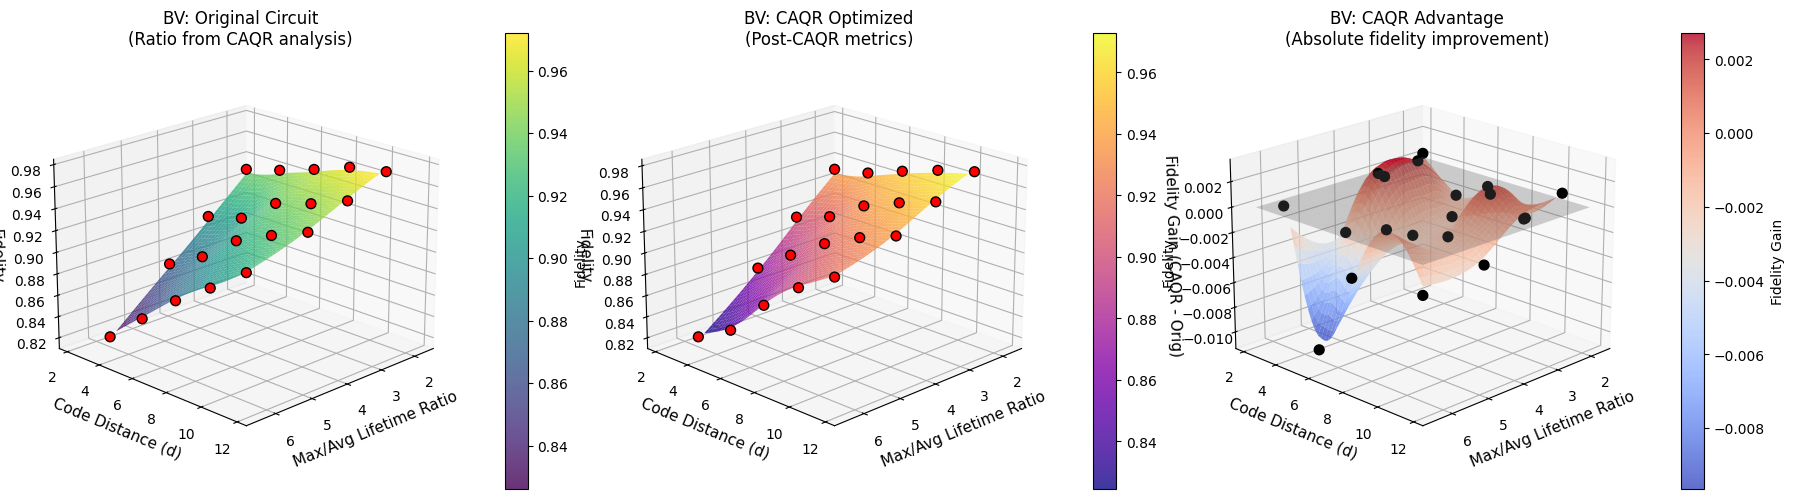

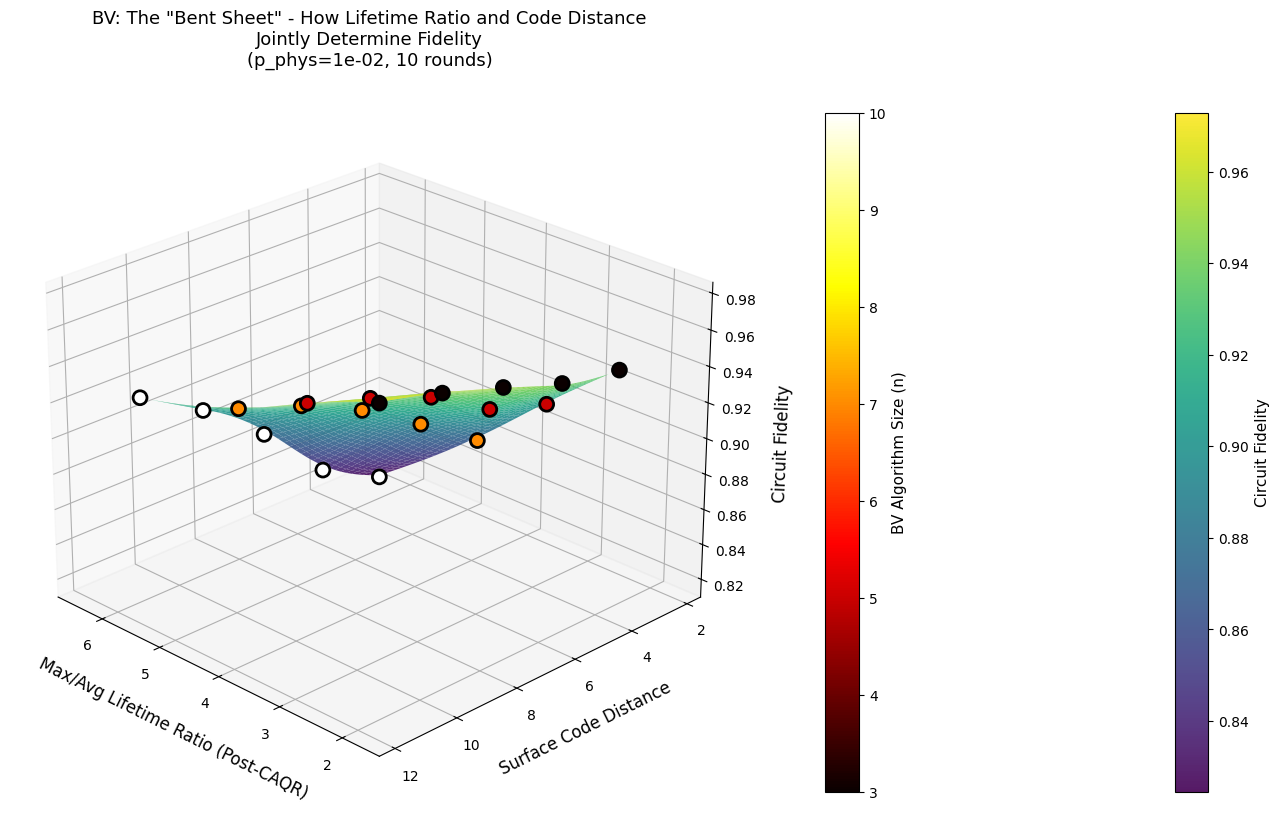


BV 3D ANALYSIS: RATIO × DISTANCE × FIDELITY
  n |   d |  Ratio |      p_L |  F_orig |  F_caqr |      ΔF |  Reuses
----------------------------------------------------------------------------------------------------
  3 |   3 |   2.15 | 8.71e-03 |  0.9372 |  0.9381 | +0.0010 |       2
  3 |   5 |   2.15 | 7.50e-03 |  0.9459 |  0.9443 | -0.0016 |       2
  3 |   7 |   2.15 | 5.92e-03 |  0.9564 |  0.9556 | -0.0007 |       2
  3 |   9 |   2.15 | 4.53e-03 |  0.9680 |  0.9663 | -0.0017 |       2
  3 |  11 |   2.15 | 3.56e-03 |  0.9736 |  0.9747 | +0.0011 |       2
  5 |   3 |   3.27 | 8.56e-03 |  0.9035 |  0.9035 | +0.0000 |       4
  5 |   5 |   3.27 | 7.59e-03 |  0.9123 |  0.9143 | +0.0021 |       4
  5 |   7 |   3.27 | 5.75e-03 |  0.9363 |  0.9347 | -0.0015 |       4
  5 |   9 |   3.27 | 4.62e-03 |  0.9461 |  0.9478 | +0.0017 |       4
  5 |  11 |   3.27 | 3.55e-03 |  0.9588 |  0.9589 | +0.0001 |       4
  7 |   3 |   4.39 | 8.78e-03 |  0.8703 |  0.8668 | -0.0035 |       6
  7 |   5 |   

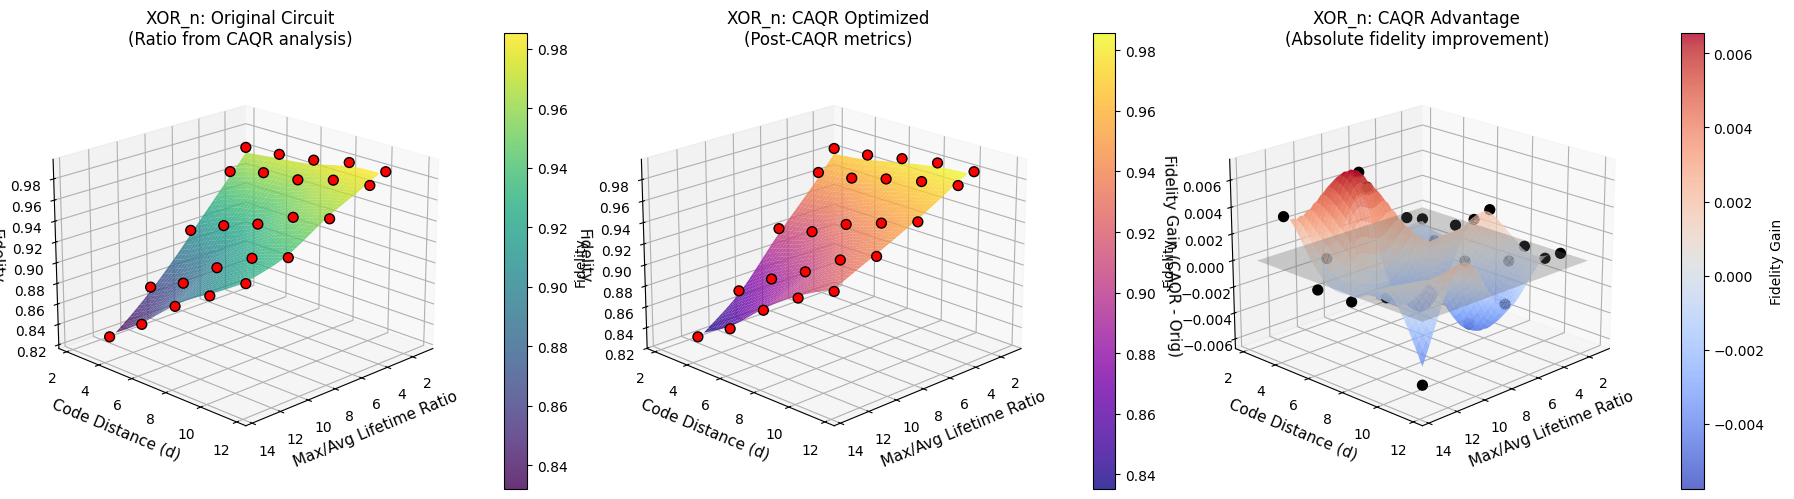

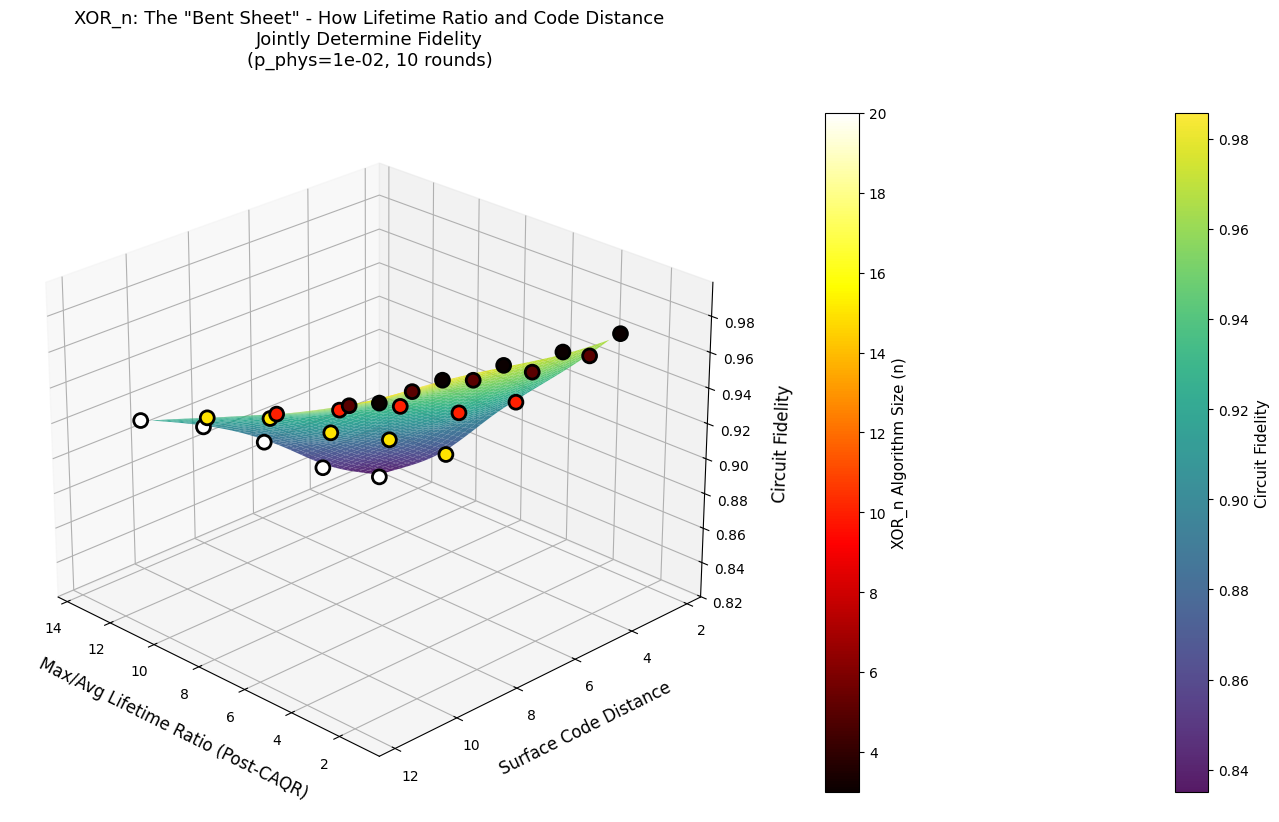


XOR_n 3D ANALYSIS: RATIO × DISTANCE × FIDELITY
  n |   d |  Ratio |      p_L |  F_orig |  F_caqr |      ΔF |  Reuses
----------------------------------------------------------------------------------------------------
  3 |   3 |   2.29 | 8.50e-03 |  0.9707 |  0.9704 | -0.0002 |       2
  3 |   5 |   2.29 | 7.41e-03 |  0.9736 |  0.9737 | +0.0001 |       2
  3 |   7 |   2.29 | 6.00e-03 |  0.9778 |  0.9799 | +0.0021 |       2
  3 |   9 |   2.29 | 4.39e-03 |  0.9854 |  0.9856 | +0.0002 |       2
  3 |  11 |   2.29 | 3.54e-03 |  0.9868 |  0.9873 | +0.0005 |       2
  5 |   3 |   3.50 | 8.70e-03 |  0.9514 |  0.9516 | +0.0002 |       4
  5 |   5 |   3.50 | 7.45e-03 |  0.9604 |  0.9562 | -0.0042 |       4
  5 |   7 |   3.50 | 5.77e-03 |  0.9636 |  0.9654 | +0.0018 |       4
  5 |   9 |   3.50 | 4.59e-03 |  0.9735 |  0.9729 | -0.0005 |       4
  5 |  11 |   3.50 | 3.56e-03 |  0.9787 |  0.9793 | +0.0006 |       4
 10 |   3 |   6.51 | 8.46e-03 |  0.9055 |  0.9091 | +0.0036 |       9
 10 |   5 |

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata

def analyze_3d_ratio_distance_fidelity(
    string_lengths: list,
    distances: list = [3, 5, 7, 9, 11],
    rounds: int = 10,
    p_phys_surface: float = 1e-2,
    shots_pL: int = 50_000,
    shots_bv: int = 20_000,
    use_bv: bool = True,
):
    """
    Create 3D plot: max/avg ratio vs distance vs fidelity.
    
    Shows how fidelity depends on both:
    - Code distance (vertical axis in plot)
    - Lifetime ratio from CAQR (horizontal axes)
    
    Expected behavior:
    - Fixed d, higher ratio → lower fidelity (long-lived qubits accumulate more errors)
    - Fixed ratio, higher d → higher fidelity (stronger error correction)
    """
    
    results = []
    
    for n in string_lengths:
        print(f"\n{'='*60}")
        circuit_type = "BV" if use_bv else "XOR_n"
        print(f"Testing {circuit_type} with n={n}")
        print('='*60)
        
        # Build circuit
        if use_bv:
            s = '1' * n
            qc_seq = QuantumCircuit(n + 1, n)
            qc_seq.x(n)
            qc_seq.h(n)
            for i in range(n):
                qc_seq.h(i)
                if s[n - 1 - i] == '1':
                    qc_seq.cx(i, n)
                qc_seq.h(i)
            for i in range(n):
                qc_seq.measure(i, i)
            secret = s
        else:
            xor_input = '1' * n
            qc_seq = build_xor_n_circuit(xor_input)
            secret = xor_parity(xor_input)
        
        # Apply CAQR
        qc_caqr, iter_count, chain = apply_caqr(qc_seq)
        
        print(f"CAQR: Reused {iter_count} qubits, Chain: {chain}")
        
        # Calculate lifetime metrics for CAQR circuit
        segments_caqr = qubit_segment_lifetimes(qc_caqr)
        all_segs_caqr = [seg for segs in segments_caqr for seg in segs]
        
        if len(all_segs_caqr) > 0:
            max_seg = max(all_segs_caqr)
            avg_seg = sum(all_segs_caqr) / len(all_segs_caqr)
            max_avg_ratio = max_seg / avg_seg if avg_seg > 0 else 0
        else:
            max_avg_ratio = 0
        
        print(f"Max/Avg lifetime ratio: {max_avg_ratio:.2f}")
        
        # Test at multiple distances
        for d in distances:
            print(f"  Testing d={d}...", end=" ")
            
            # Estimate logical error rate for this distance
            pL = estimate_pL_surface_code(
                distance=d,
                rounds=rounds,
                p_phys=p_phys_surface,
                shots=shots_pL
            )
            
            # Measure fidelity for both original and CAQR
            fidelity_orig = run_bv_on_stim(qc_seq, secret, p1=pL, p2=pL,
                                          shots=shots_bv, label=f"n={n}, d={d}")
            fidelity_caqr = run_bv_on_stim(qc_caqr, secret, p1=pL, p2=pL,
                                          shots=shots_bv, label=f"n={n}, d={d}, CAQR")
            
            print(f"F_orig={fidelity_orig:.4f}, F_caqr={fidelity_caqr:.4f}")
            
            results.append({
                'n': n,
                'distance': d,
                'pL': pL,
                'ratio': max_avg_ratio,
                'fidelity_orig': fidelity_orig,
                'fidelity_caqr': fidelity_caqr,
                'num_reuses': iter_count,
            })
    
    # Prepare data for surface plotting
    circuit_name = "BV" if use_bv else "XOR_n"
    
    ratios = np.array([r['ratio'] for r in results])
    distances_data = np.array([r['distance'] for r in results])
    fidelities_orig = np.array([r['fidelity_orig'] for r in results])
    fidelities_caqr = np.array([r['fidelity_caqr'] for r in results])
    ns = np.array([r['n'] for r in results])
    
    # Create interpolated grid for smooth surface
    # Define grid resolution
    grid_resolution = 50
    ratio_min, ratio_max = ratios.min(), ratios.max()
    dist_min, dist_max = distances_data.min(), distances_data.max()
    
    # Add padding to make surface extend beyond data points
    ratio_padding = (ratio_max - ratio_min) * 0.1
    dist_padding = (dist_max - dist_min) * 0.1
    
    ratio_grid = np.linspace(ratio_min - ratio_padding, ratio_max + ratio_padding, grid_resolution)
    dist_grid = np.linspace(dist_min - dist_padding, dist_max + dist_padding, grid_resolution)
    ratio_mesh, dist_mesh = np.meshgrid(ratio_grid, dist_grid)
    
    # Interpolate fidelity values onto grid
    points = np.column_stack([ratios, distances_data])
    fidelity_orig_mesh = griddata(points, fidelities_orig, (ratio_mesh, dist_mesh), method='cubic')
    fidelity_caqr_mesh = griddata(points, fidelities_caqr, (ratio_mesh, dist_mesh), method='cubic')
    fidelity_gain_mesh = fidelity_caqr_mesh - fidelity_orig_mesh
    
    # Create 3D surface plots
    fig = plt.figure(figsize=(18, 6))
    
    # Plot 1: Original circuits
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(ratio_mesh, dist_mesh, fidelity_orig_mesh,
                             cmap='viridis', alpha=0.8, edgecolor='none',
                             linewidth=0, antialiased=True)
    # Add scatter points for actual data
    ax1.scatter(ratios, distances_data, fidelities_orig, 
               c='red', s=50, alpha=1.0, edgecolors='k', linewidths=1, zorder=10)
    ax1.set_xlabel('Max/Avg Lifetime Ratio', fontsize=11)
    ax1.set_ylabel('Code Distance (d)', fontsize=11)
    ax1.set_zlabel('Fidelity', fontsize=11)
    ax1.set_title(f'{circuit_name}: Original Circuit\n(Ratio from CAQR analysis)', fontsize=12)
    ax1.view_init(elev=20, azim=45)
    cbar1 = fig.colorbar(surf1, ax=ax1, pad=0.1, shrink=0.8)
    cbar1.set_label('Fidelity', fontsize=10)
    
    # Plot 2: CAQR optimized circuits
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(ratio_mesh, dist_mesh, fidelity_caqr_mesh,
                             cmap='plasma', alpha=0.8, edgecolor='none',
                             linewidth=0, antialiased=True)
    # Add scatter points for actual data
    ax2.scatter(ratios, distances_data, fidelities_caqr,
               c='red', s=50, alpha=1.0, edgecolors='k', linewidths=1, zorder=10)
    ax2.set_xlabel('Max/Avg Lifetime Ratio', fontsize=11)
    ax2.set_ylabel('Code Distance (d)', fontsize=11)
    ax2.set_zlabel('Fidelity', fontsize=11)
    ax2.set_title(f'{circuit_name}: CAQR Optimized\n(Post-CAQR metrics)', fontsize=12)
    ax2.view_init(elev=20, azim=45)
    cbar2 = fig.colorbar(surf2, ax=ax2, pad=0.1, shrink=0.8)
    cbar2.set_label('Fidelity', fontsize=10)
    
    # Plot 3: Fidelity gain (CAQR - Original)
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = ax3.plot_surface(ratio_mesh, dist_mesh, fidelity_gain_mesh,
                             cmap='coolwarm', alpha=0.8, edgecolor='none',
                             linewidth=0, antialiased=True)
    # Add scatter points for actual data
    fidelity_gains = fidelities_caqr - fidelities_orig
    ax3.scatter(ratios, distances_data, fidelity_gains,
               c='black', s=50, alpha=1.0, edgecolors='k', linewidths=1, zorder=10)
    ax3.set_xlabel('Max/Avg Lifetime Ratio', fontsize=11)
    ax3.set_ylabel('Code Distance (d)', fontsize=11)
    ax3.set_zlabel('Fidelity Gain (CAQR - Orig)', fontsize=11)
    ax3.set_title(f'{circuit_name}: CAQR Advantage\n(Absolute fidelity improvement)', fontsize=12)
    ax3.view_init(elev=20, azim=45)
    # Add zero-plane for reference
    xx, yy = np.meshgrid(np.linspace(ratio_min - ratio_padding, ratio_max + ratio_padding, 10),
                         np.linspace(dist_min - dist_padding, dist_max + dist_padding, 10))
    zz = np.zeros_like(xx)
    ax3.plot_surface(xx, yy, zz, alpha=0.3, color='gray')
    cbar3 = fig.colorbar(surf3, ax=ax3, pad=0.1, shrink=0.8)
    cbar3.set_label('Fidelity Gain', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Create a single large "bent sheet" visualization
    fig2 = plt.figure(figsize=(14, 10))
    ax = fig2.add_subplot(111, projection='3d')
    
    # Plot CAQR surface
    surf = ax.plot_surface(ratio_mesh, dist_mesh, fidelity_caqr_mesh,
                          cmap='viridis', alpha=0.9, edgecolor='none',
                          linewidth=0, antialiased=True, shade=True)
    
    # Add contour lines at the bottom for better depth perception
    contours = ax.contour(ratio_mesh, dist_mesh, fidelity_caqr_mesh,
                         levels=10, zdir='z', offset=fidelity_caqr_mesh.min() - 0.05,
                         cmap='viridis', alpha=0.4, linewidths=1)
    
    # Add scatter points for actual measurements
    scatter = ax.scatter(ratios, distances_data, fidelities_caqr,
                        c=ns, cmap='hot', s=100, alpha=1.0, 
                        edgecolors='black', linewidths=2, zorder=10,
                        label='Measured Data Points')
    
    ax.set_xlabel('Max/Avg Lifetime Ratio (Post-CAQR)', fontsize=12, labelpad=10)
    ax.set_ylabel('Surface Code Distance', fontsize=12, labelpad=10)
    ax.set_zlabel('Circuit Fidelity', fontsize=12, labelpad=10)
    ax.set_title(f'{circuit_name}: The "Bent Sheet" - How Lifetime Ratio and Code Distance\n'
                 'Jointly Determine Fidelity\n'
                 f'(p_phys={p_phys_surface:.0e}, {rounds} rounds)', 
                 fontsize=13, pad=20)
    ax.view_init(elev=25, azim=135)
    
    # Color bar for the surface
    cbar = plt.colorbar(surf, ax=ax, pad=0.15, shrink=0.7)
    cbar.set_label('Circuit Fidelity', fontsize=11)
    
    # Color bar for the data points
    cbar2 = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.7)
    cbar2.set_label(f'{circuit_name} Algorithm Size (n)', fontsize=11)
    
    # Add grid for better depth perception
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*100)
    print(f"{circuit_name} 3D ANALYSIS: RATIO × DISTANCE × FIDELITY")
    print("="*100)
    print(f"{'n':>3} | {'d':>3} | {'Ratio':>6} | {'p_L':>8} | {'F_orig':>7} | {'F_caqr':>7} | {'ΔF':>7} | {'Reuses':>7}")
    print("-"*100)
    for r in results:
        delta_f = r['fidelity_caqr'] - r['fidelity_orig']
        print(f"{r['n']:3d} | {r['distance']:3d} | {r['ratio']:6.2f} | {r['pL']:8.2e} | "
              f"{r['fidelity_orig']:7.4f} | {r['fidelity_caqr']:7.4f} | "
              f"{delta_f:+7.4f} | {r['num_reuses']:7d}")
    
    print("\n" + "="*100)
    print("KEY OBSERVATIONS:")
    print("  • For fixed distance: Higher ratio → Lower fidelity (long-lived qubits accumulate errors)")
    print("  • For fixed ratio: Higher distance → Higher fidelity (stronger error correction)")
    print("  • The 'bent sheet' shows the joint effect of both parameters")
    print("  • Future work: Heterogeneous distances - larger patches for long-lived qubits only")
    print("="*100)
    
    return results

# Run for BV circuits
print("\n" + "="*100)
print("ANALYZING BV CIRCUITS - 3D: RATIO × DISTANCE × FIDELITY")
print("="*100)
bv_3d_results = analyze_3d_ratio_distance_fidelity(
    string_lengths=[3, 5, 7, 10],
    distances=[3, 5, 7, 9, 11],
    rounds=10,
    p_phys_surface=1e-2,
    shots_pL=50_000,
    shots_bv=20_000,
    use_bv=True,
)

# Run for XOR_n circuits
print("\n\n" + "="*100)
print("ANALYZING XOR_n CIRCUITS - 3D: RATIO × DISTANCE × FIDELITY")
print("="*100)
xor_3d_results = analyze_3d_ratio_distance_fidelity(
    string_lengths=[3, 5, 10, 15, 20],
    distances=[3, 5, 7, 9, 11],
    rounds=10,
    p_phys_surface=1e-2,
    shots_pL=50_000,
    shots_bv=20_000,
    use_bv=False,
)